In [10]:
import os
import pandas as pd
from sklearn.datasets import load_svmlight_file

In [11]:
def find_project_root(project_name="Gas_Sensor"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.basename(current_dir) == project_name:
            return current_dir
        parent = os.path.dirname(current_dir)
        if parent == current_dir:
            raise FileNotFoundError(f"Project root '{project_name}' not found.")
        current_dir = parent

# Get root and dataset path
root_dir = find_project_root()
dataset_dir = os.path.join(root_dir, "artifacts", "data_ingestion", "Dataset")

# Function to load a single .dat file
def load_dat_file(file_path):
    data, target = load_svmlight_file(file_path, n_features=128)
    data = data.toarray()
    df = pd.DataFrame(data, columns=[f'feature_{i+1}' for i in range(128)])
    df['target'] = target.astype(int)
    return df


# Load and combine all batch files
all_data = []
for batch_id in range(1, 11):
    file_path = os.path.join(dataset_dir, f'batch{batch_id}.dat')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Missing: {file_path}")
    batch_df = load_dat_file(file_path)
    all_data.append(batch_df)

# Combine into one DataFrame
data = pd.concat(all_data, ignore_index=True)
print(data.head())


    feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  15596.1621   1.868245   2.371604   2.803678   7.512213  -2.739388   
1  26402.0704   2.532401   5.411209   6.509906   7.658469  -4.722217   
2  42103.5820   3.454189   8.198175  10.508439  11.611003  -7.668313   
3  42825.9883   3.451192  12.113940  16.266853  39.910056  -7.849409   
4  58151.1757   4.194839  11.455096  15.715298  17.654915 -11.083364   

   feature_7  feature_8   feature_9  feature_10  ...  feature_120  \
0  -3.344671  -4.847512  15326.6914    1.768526  ...    -3.037772   
1  -5.817651  -7.518333  23855.7812    2.164706  ...    -1.994993   
2  -9.478675 -12.230939  37562.3008    2.840403  ...    -2.867291   
3  -9.689894 -11.921704  38379.0664    2.851173  ...    -3.058086   
4 -13.580692 -16.407848  51975.5899    3.480866  ...    -4.181920   

   feature_121  feature_122  feature_123  feature_124  feature_125  \
0    3037.0390     3.972203     0.527291     0.728443     1.445783   
1    4176.44

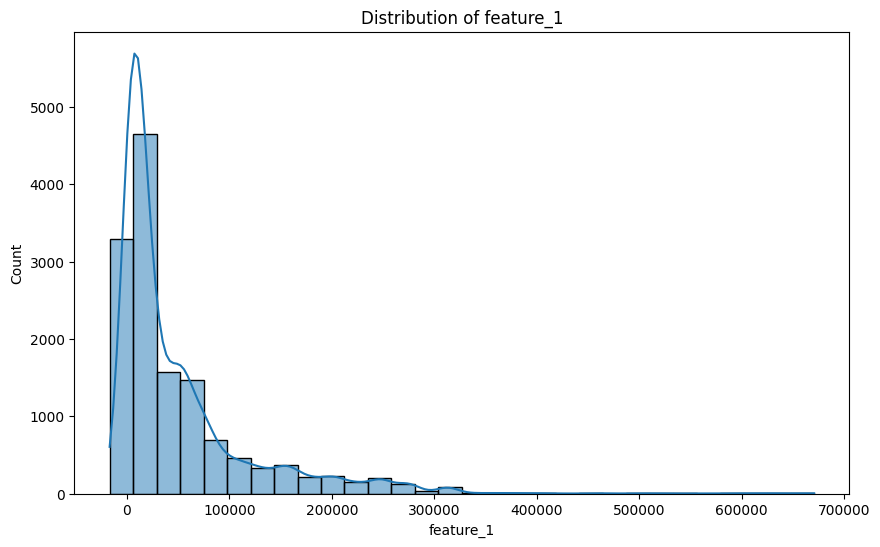

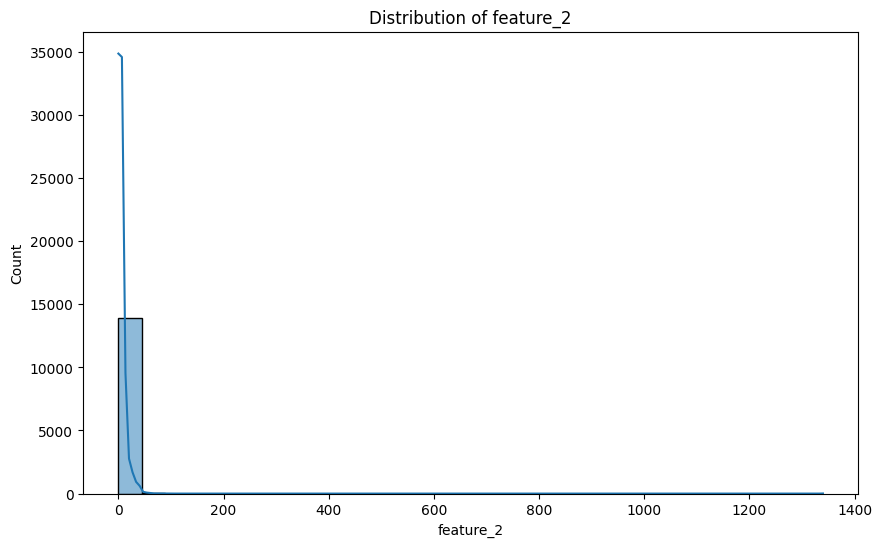

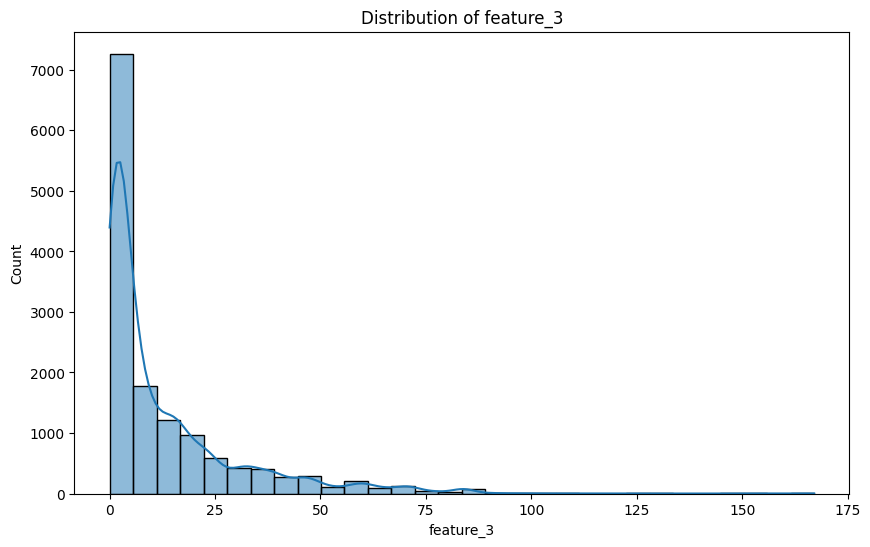

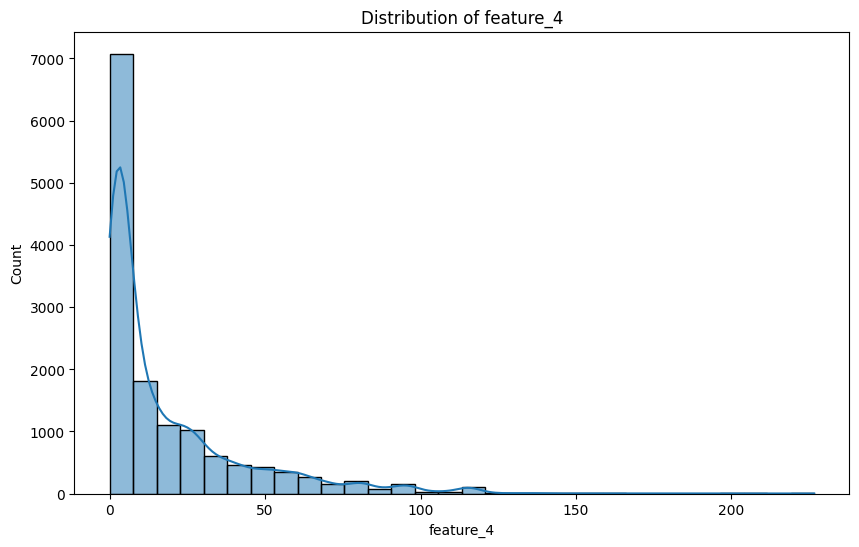

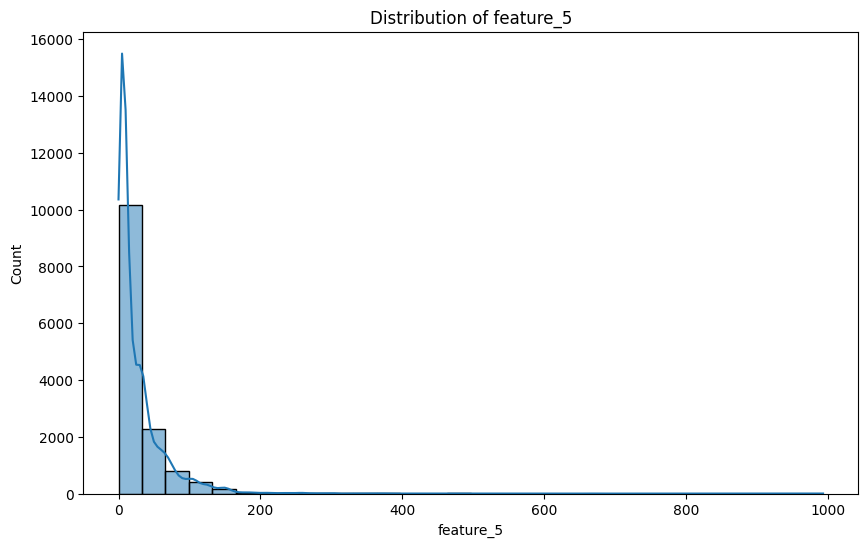

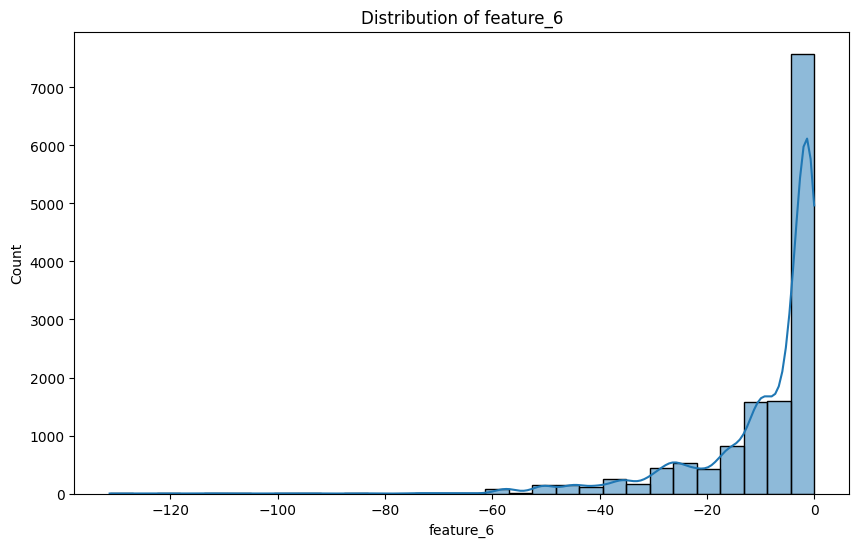

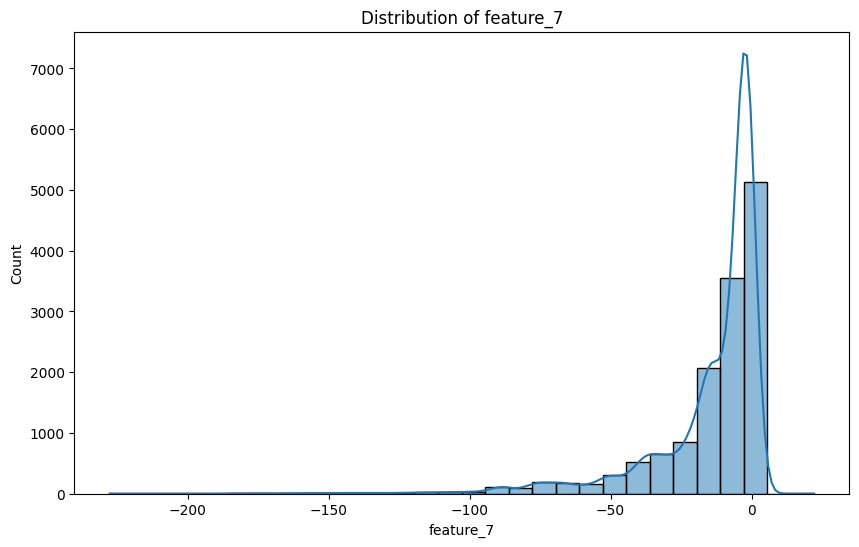

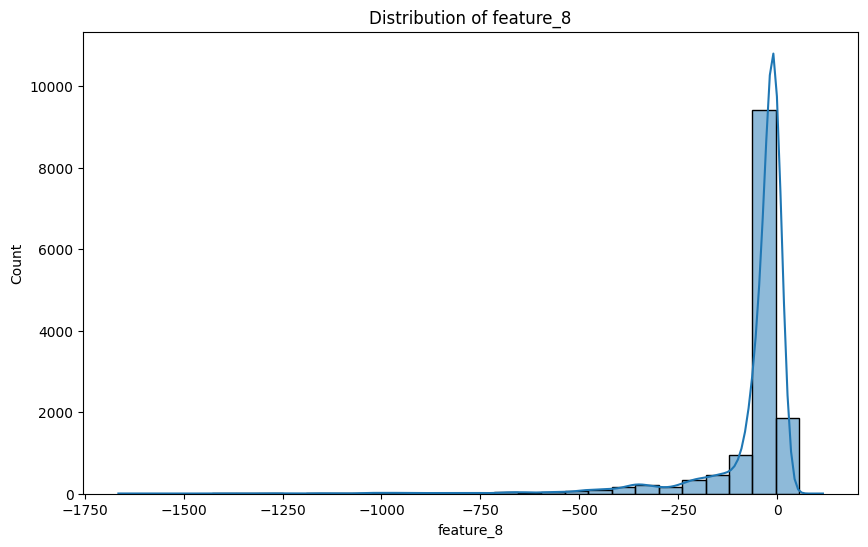

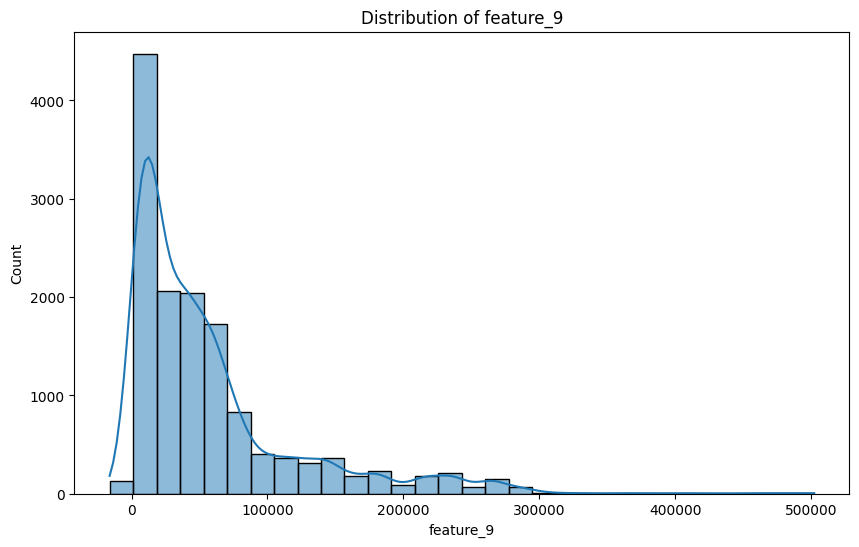

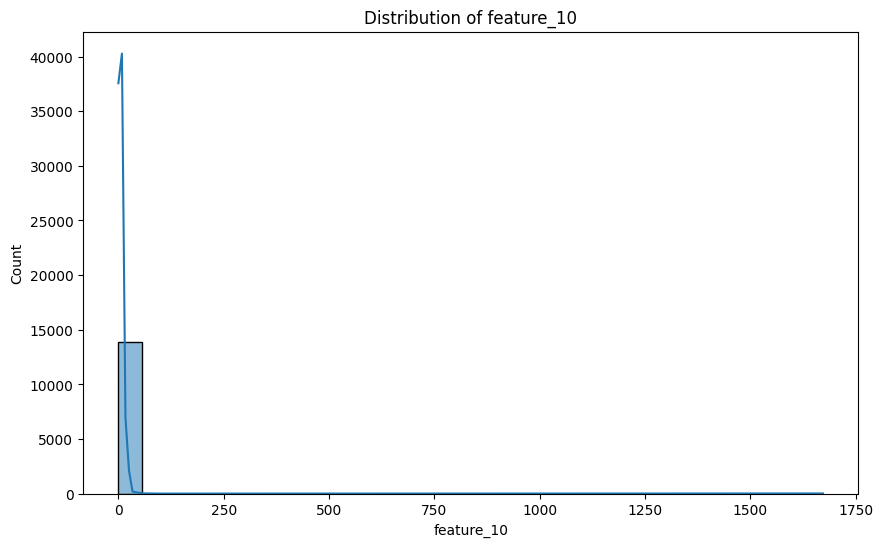

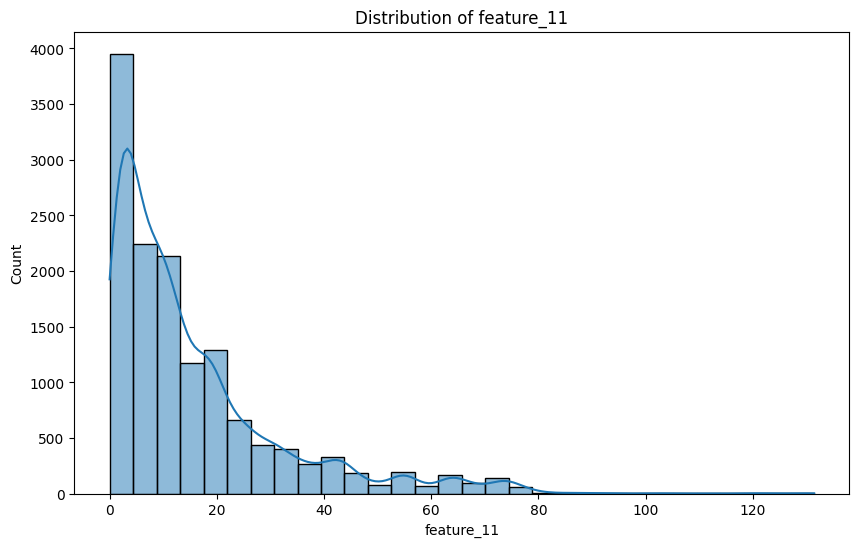

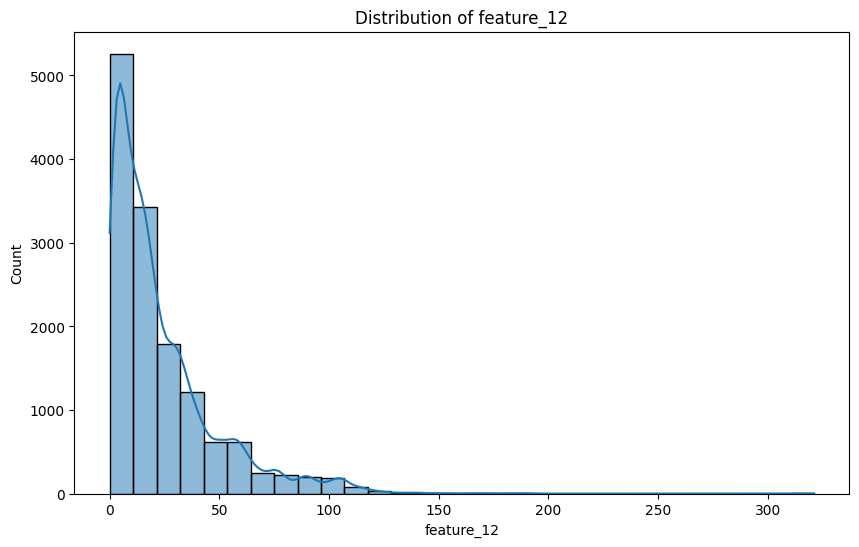

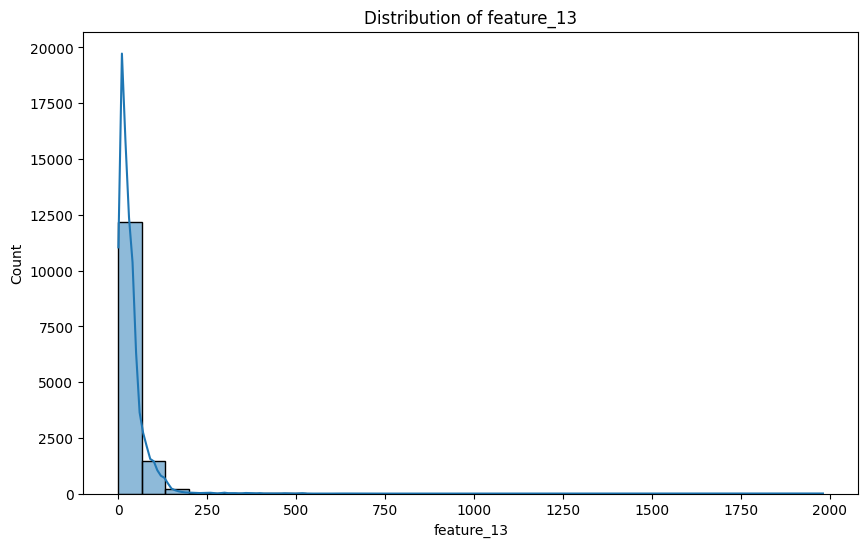

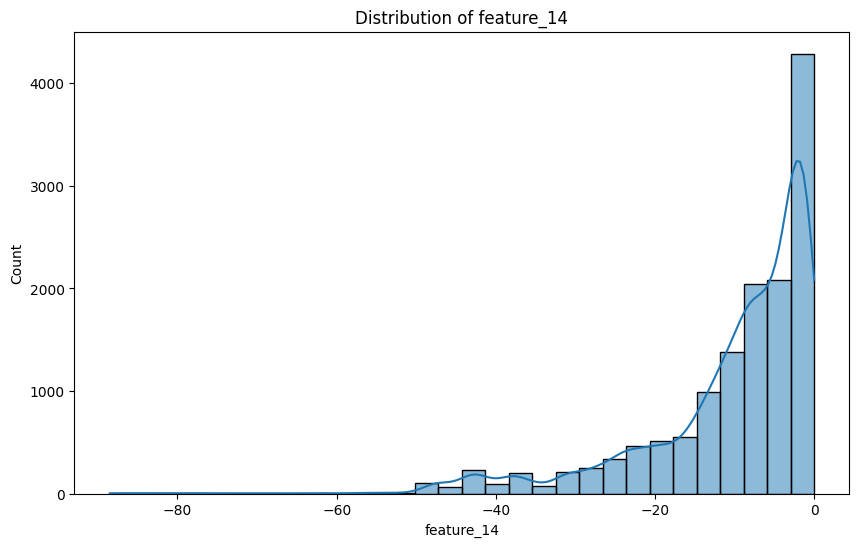

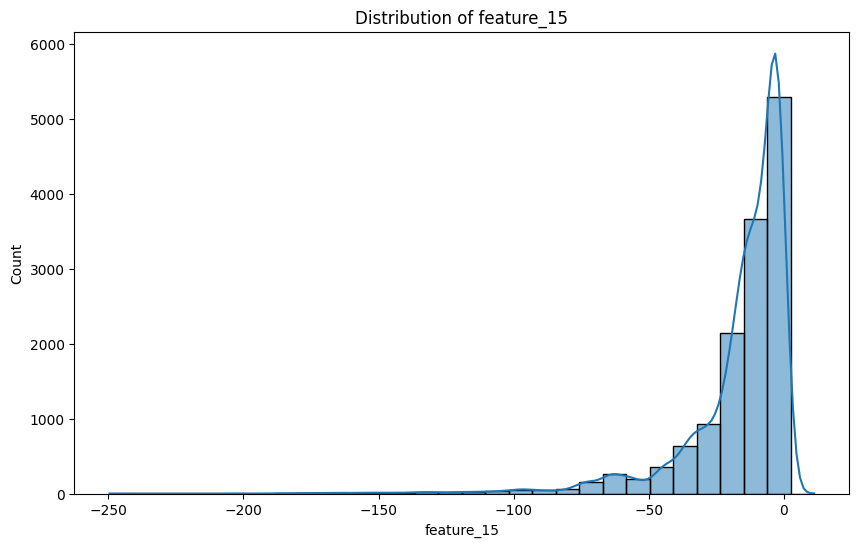

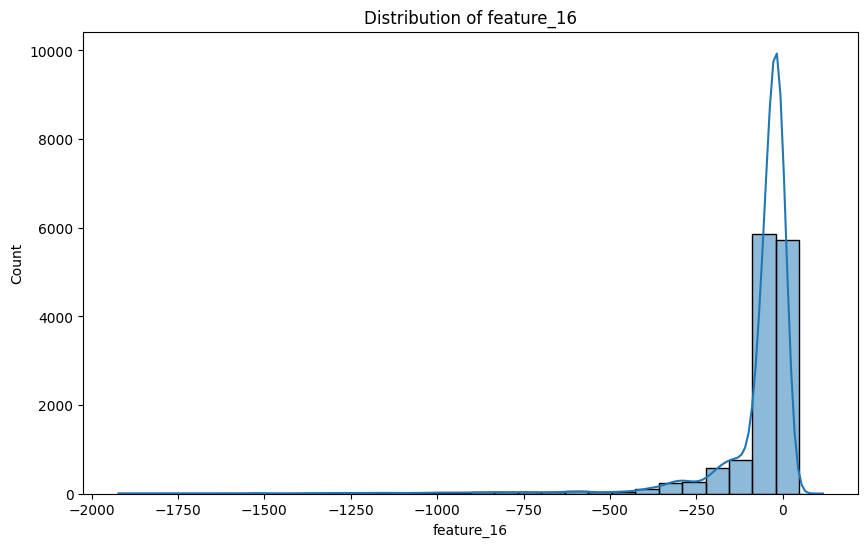

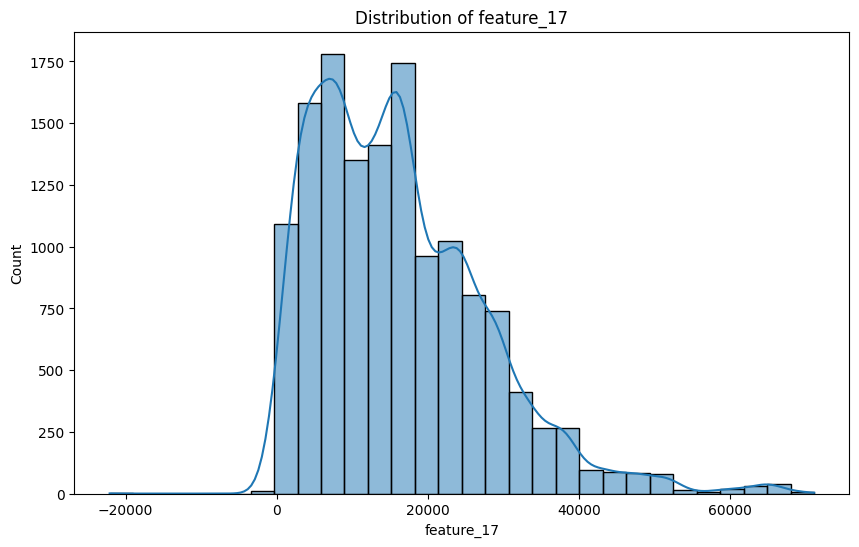

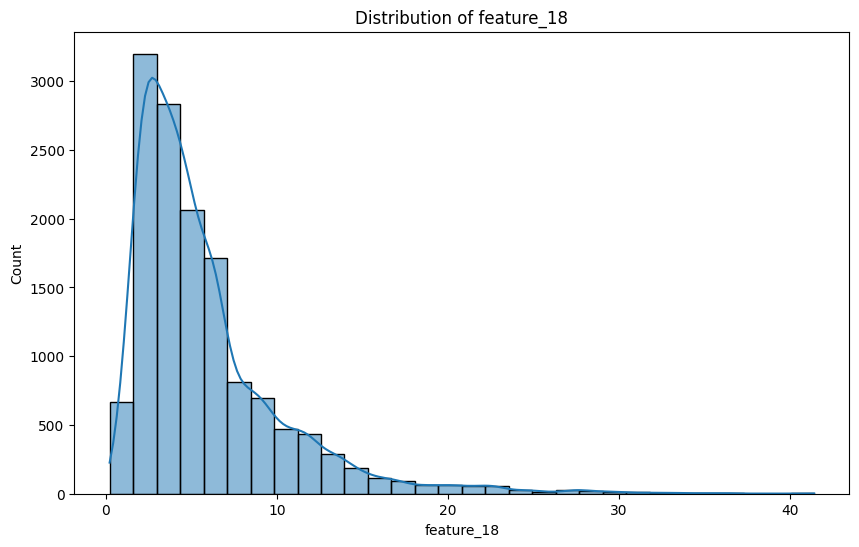

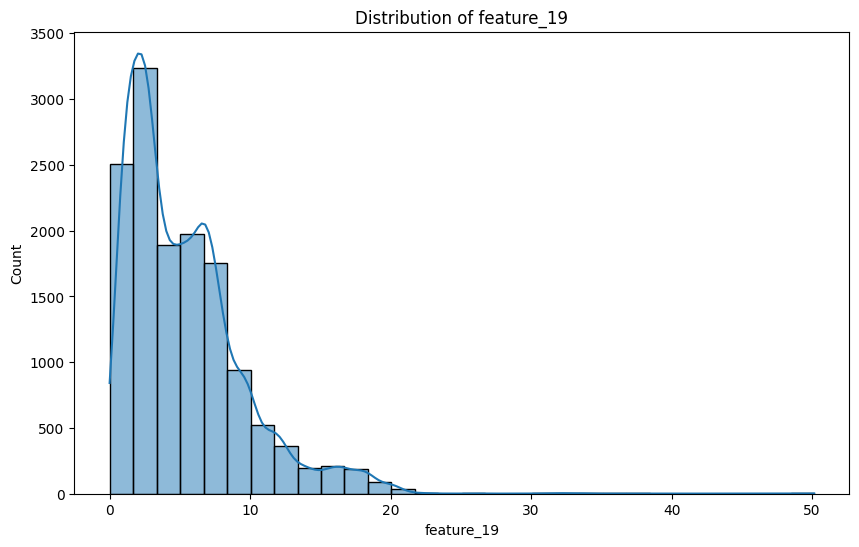

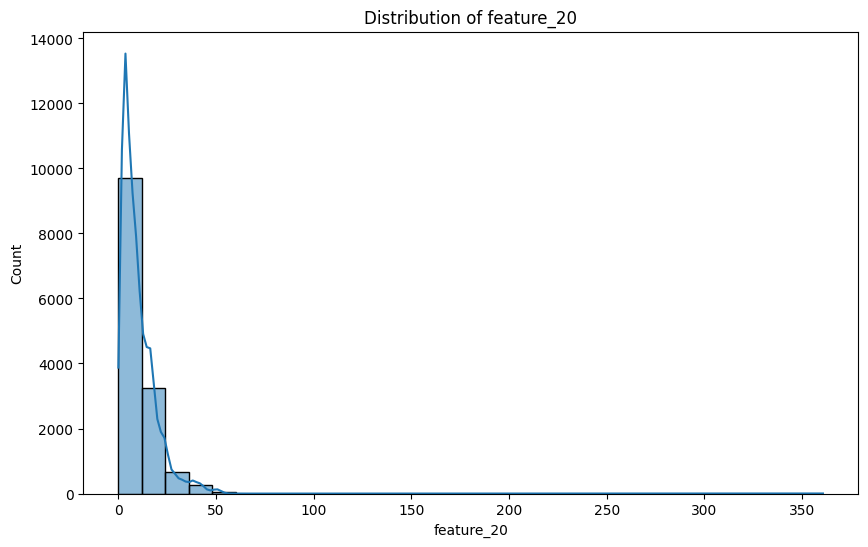

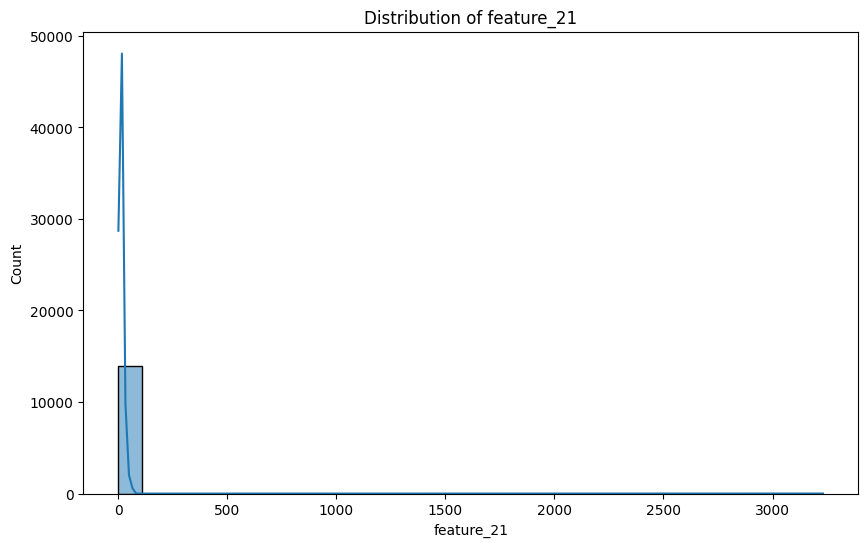

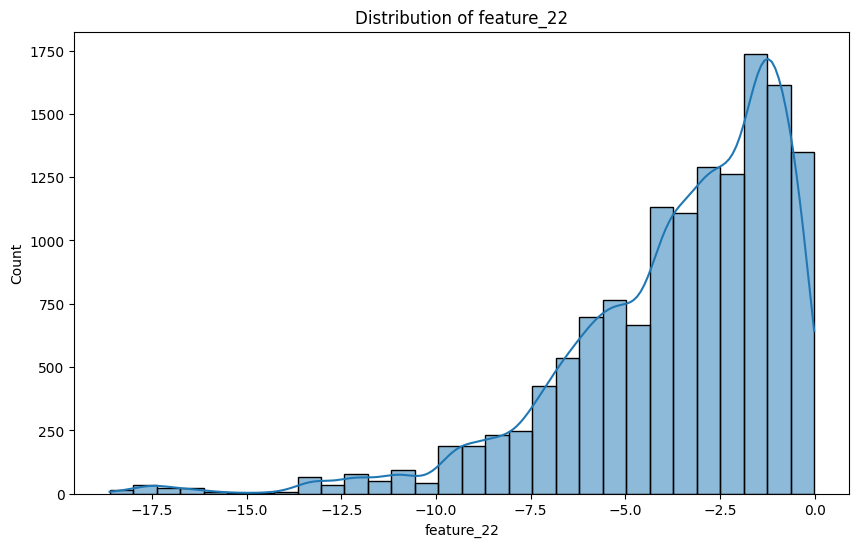

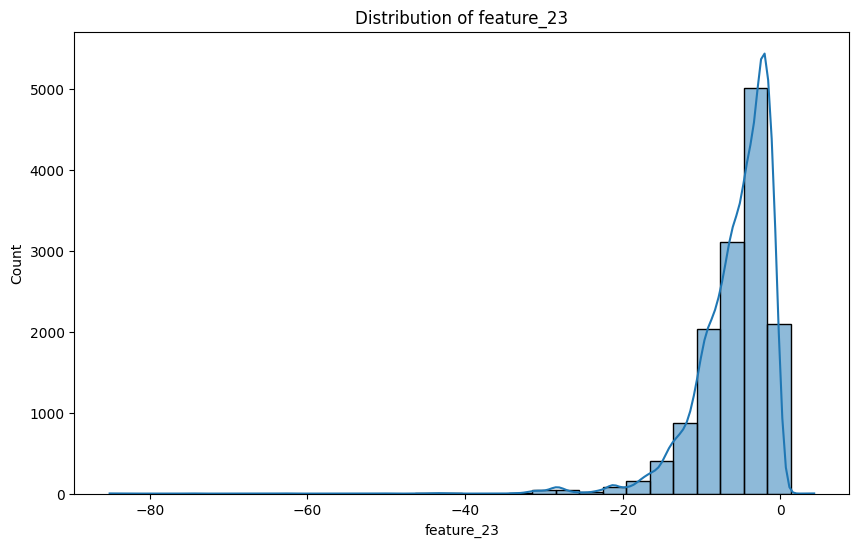

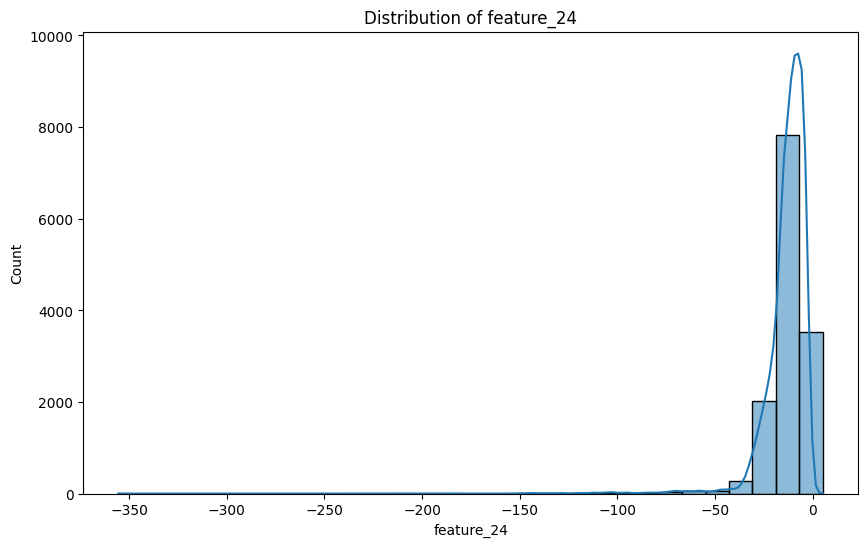

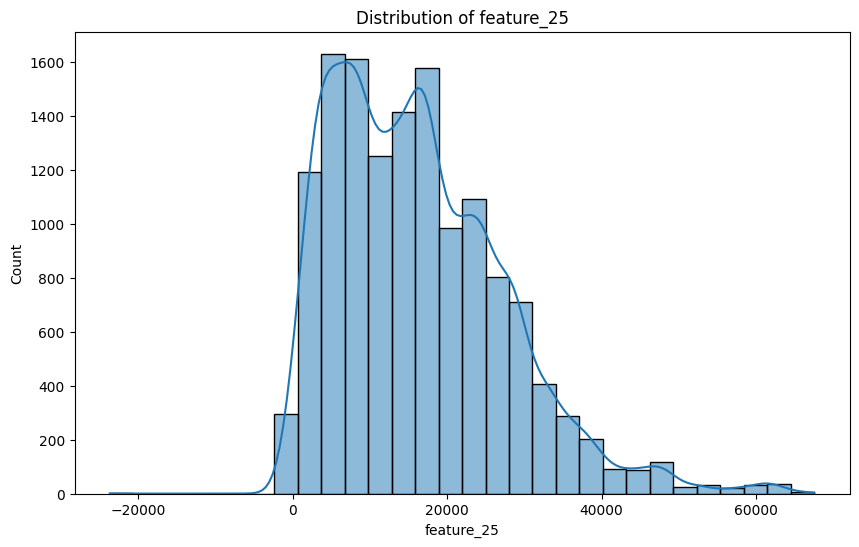

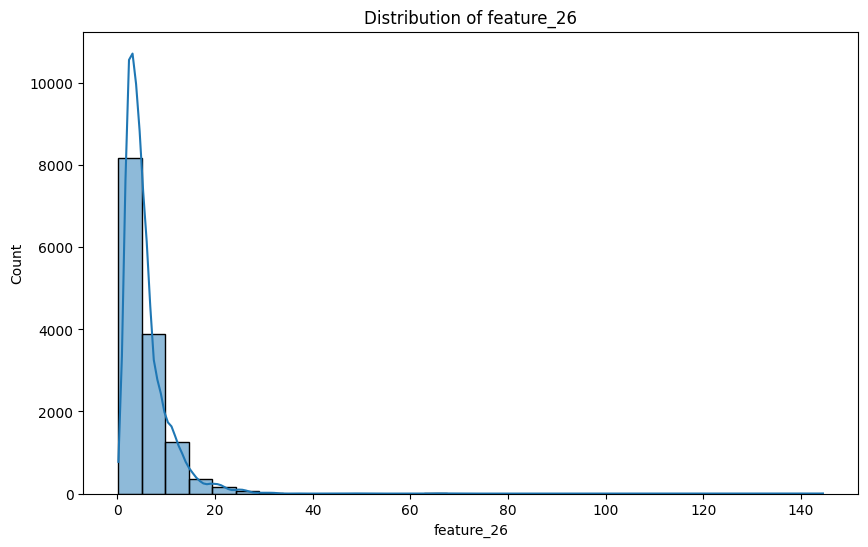

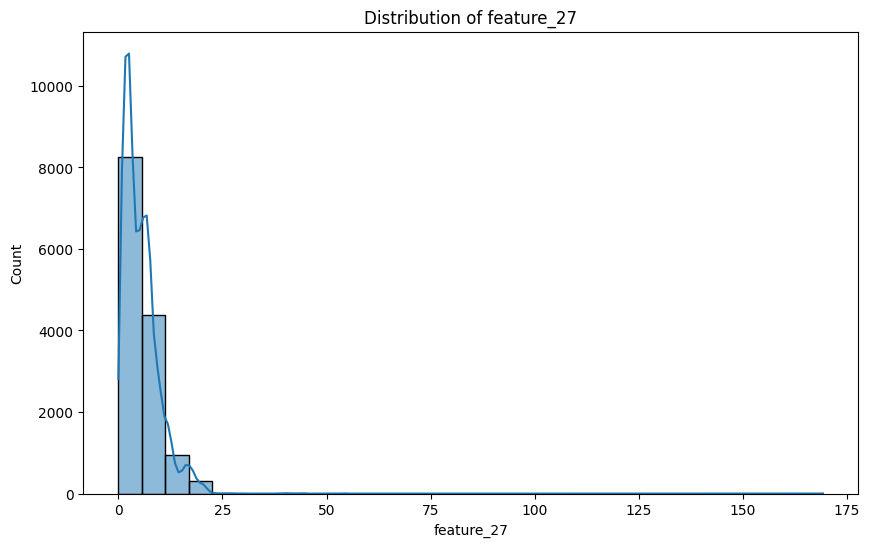

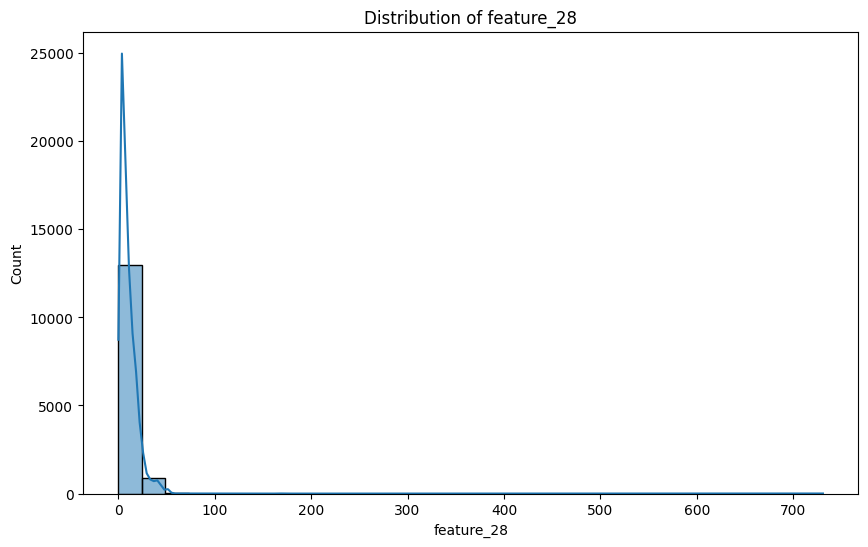

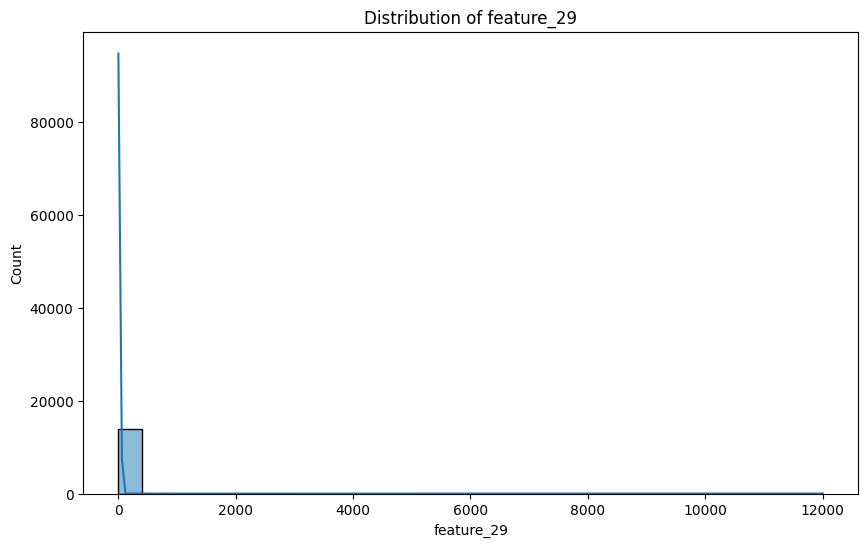

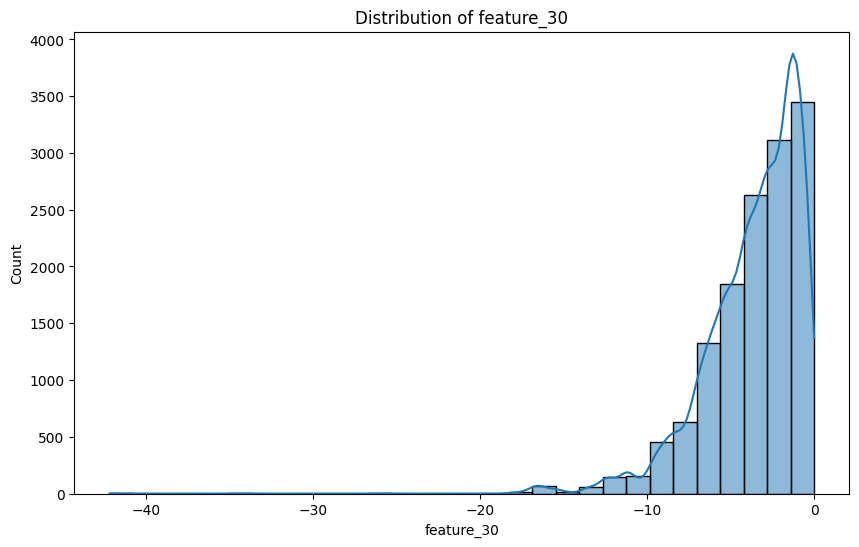

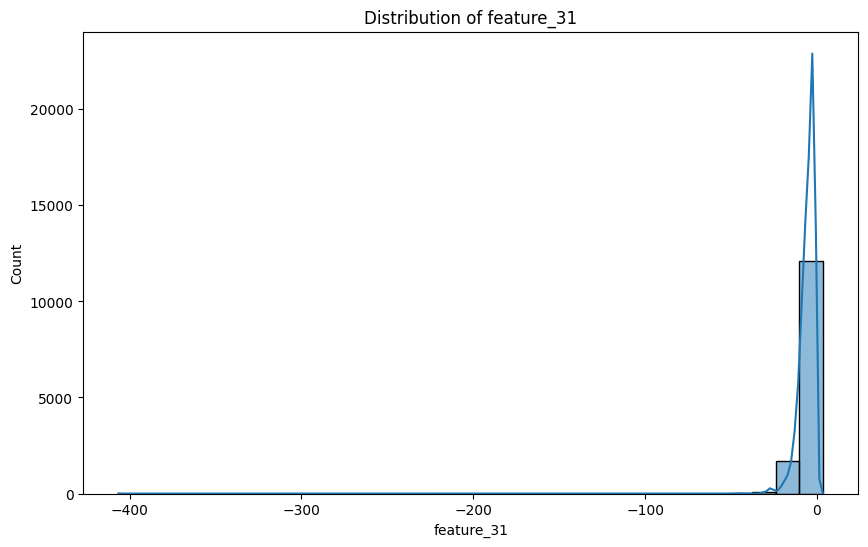

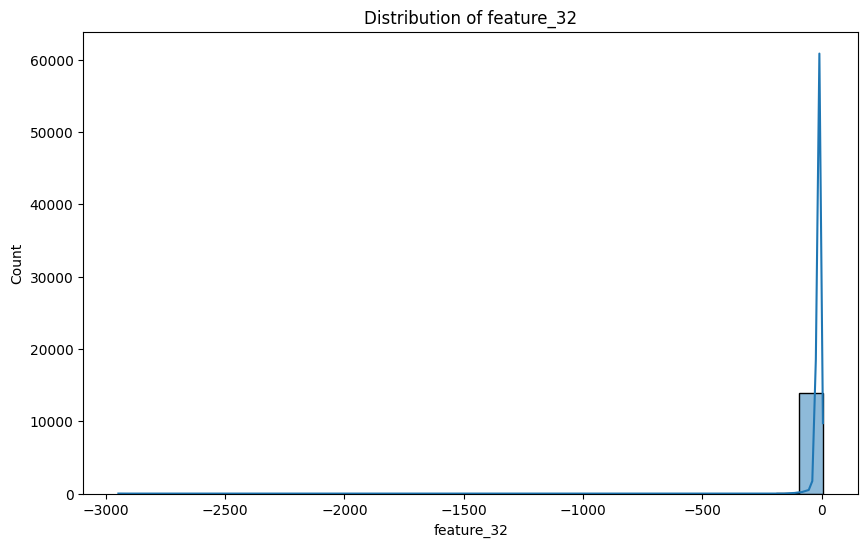

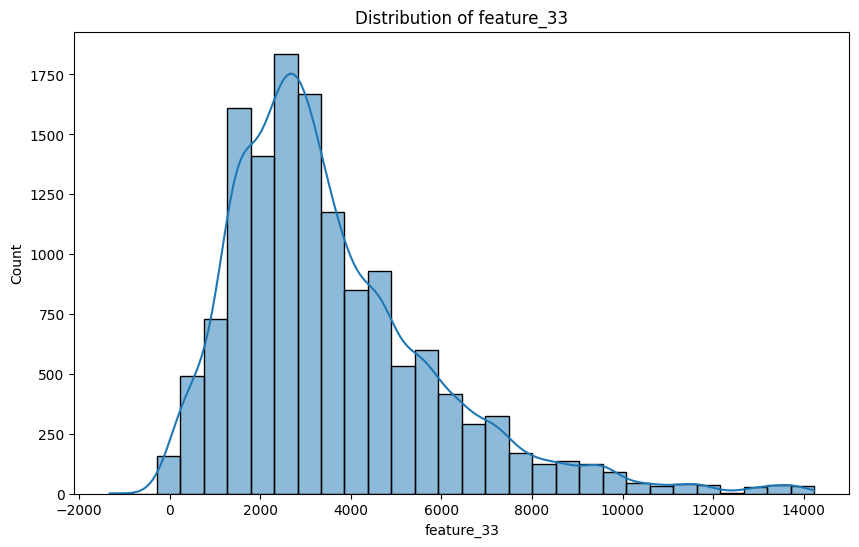

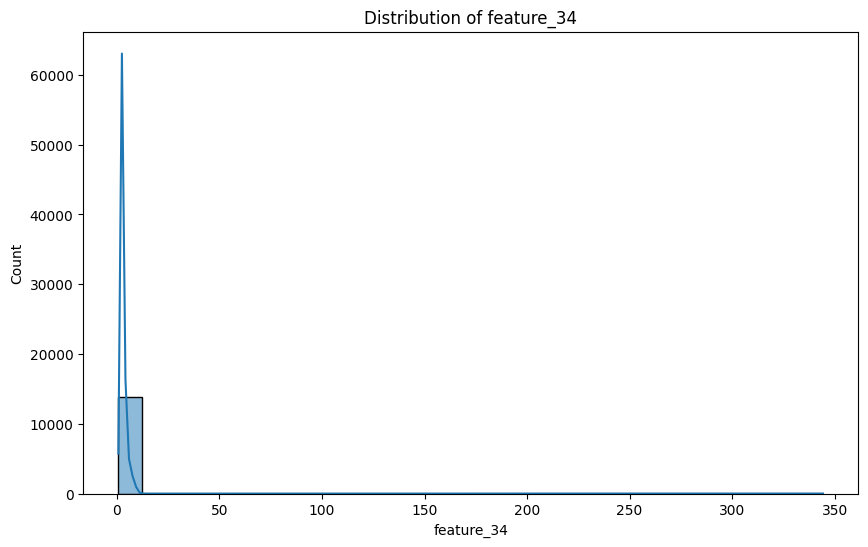

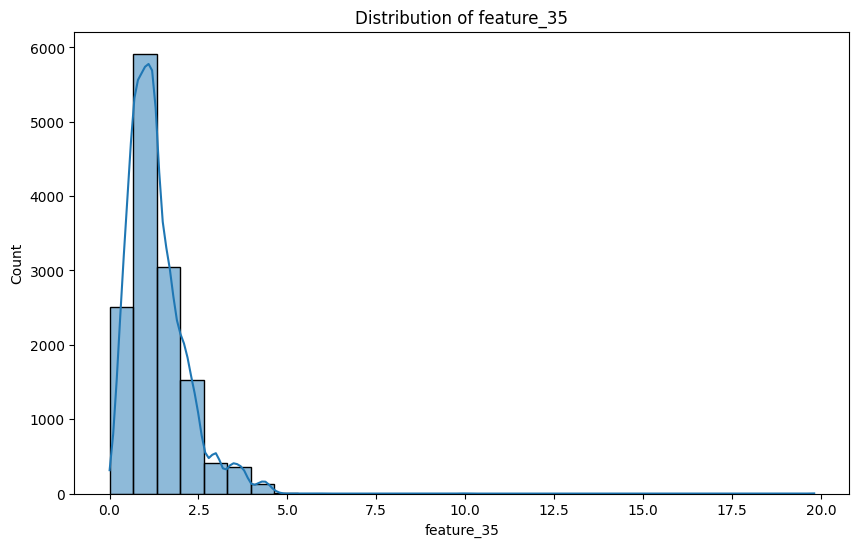

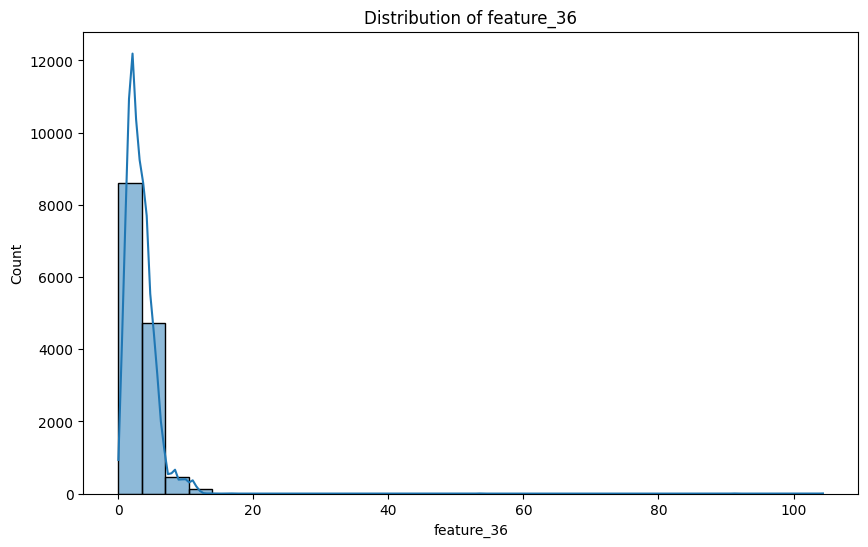

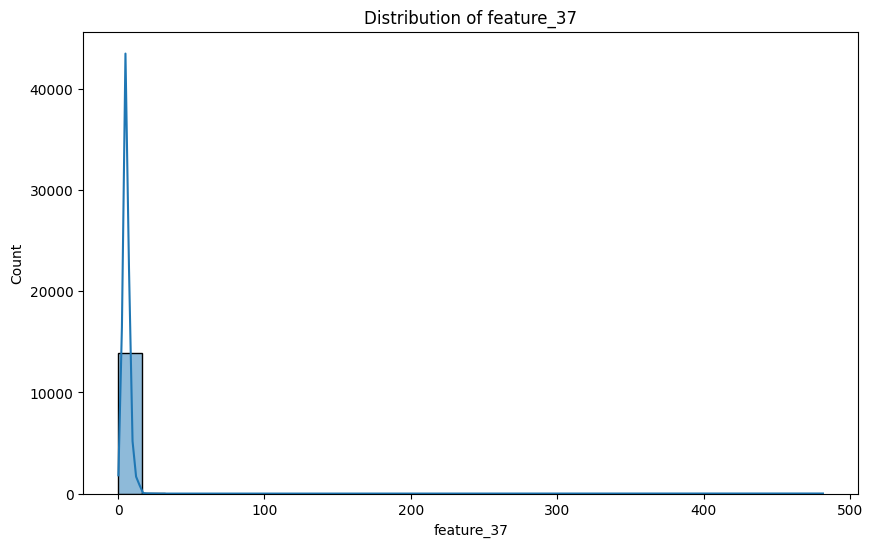

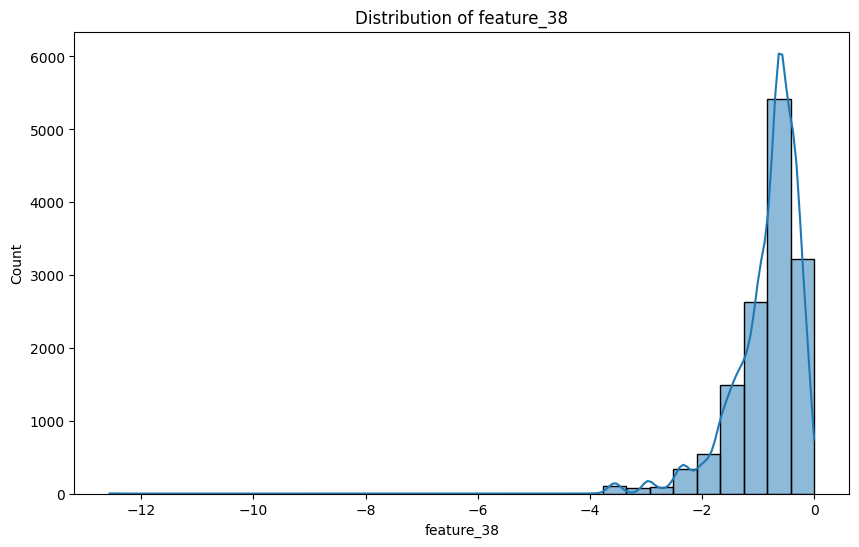

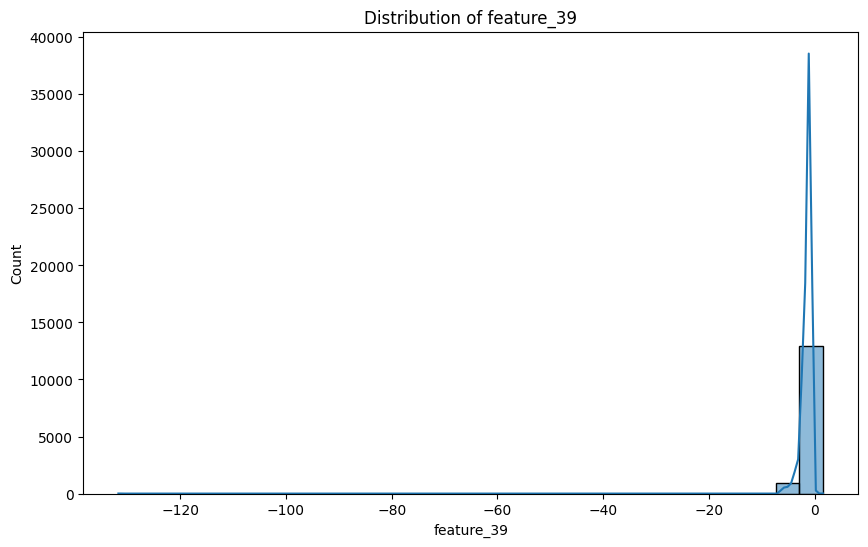

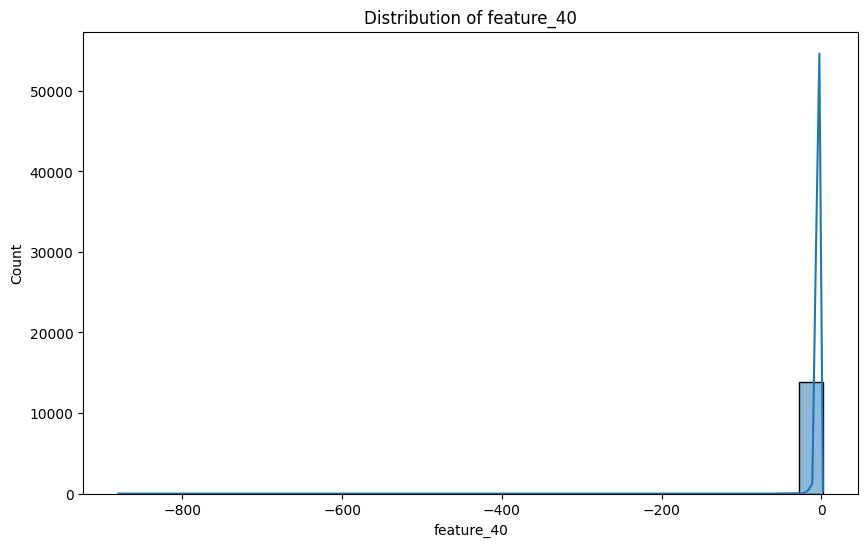

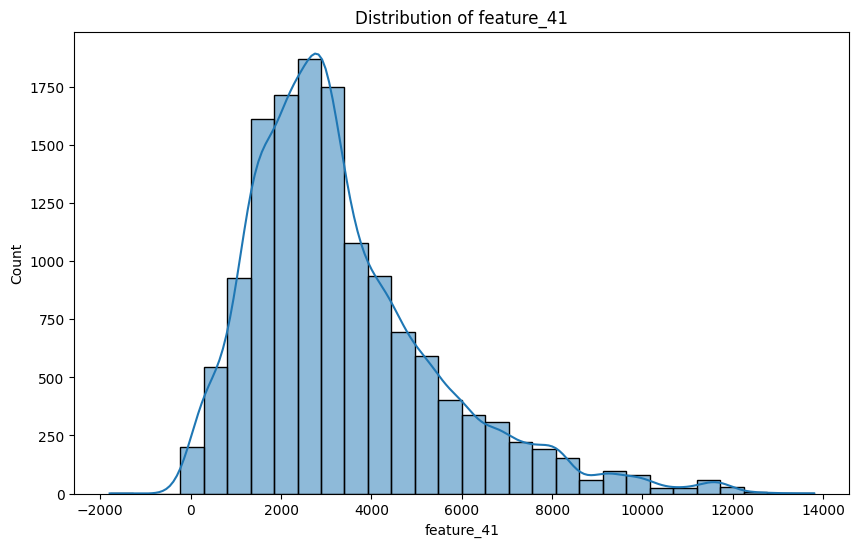

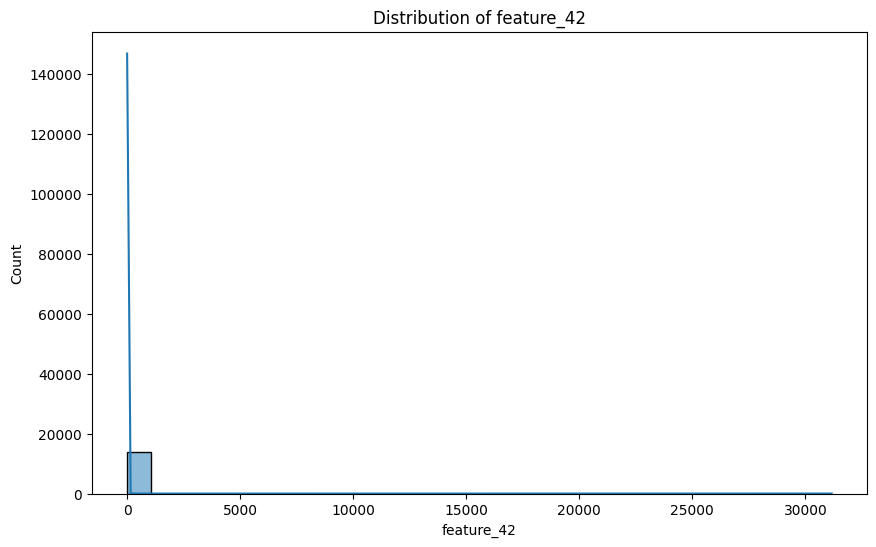

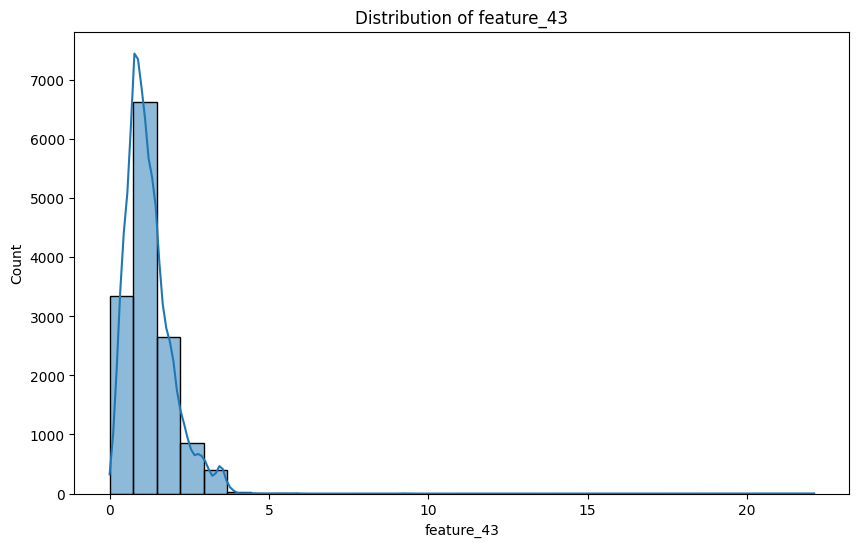

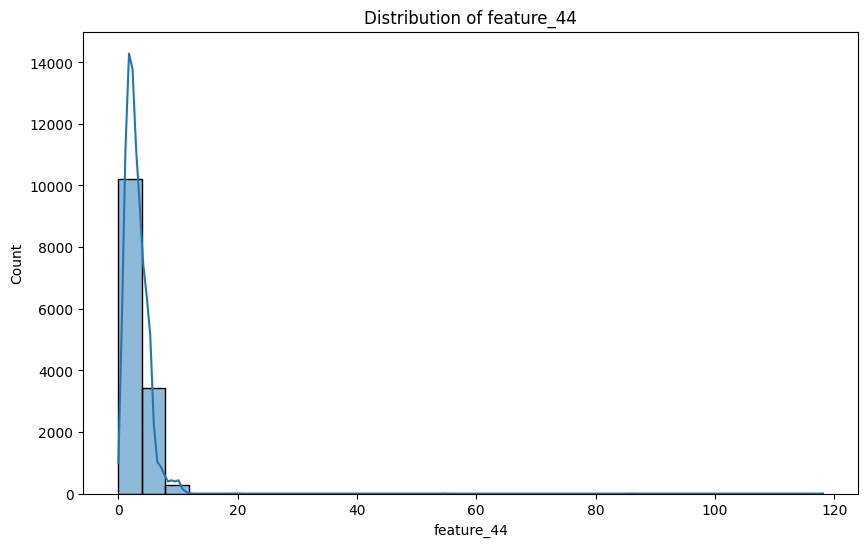

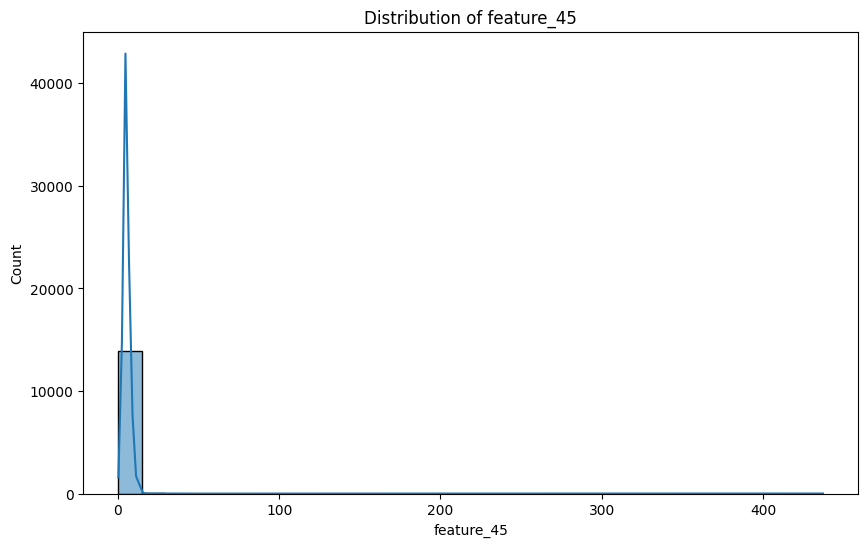

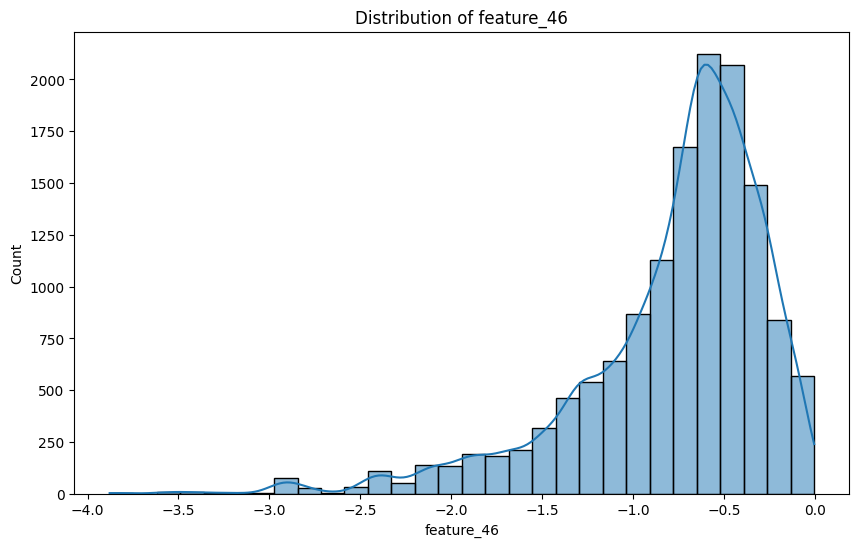

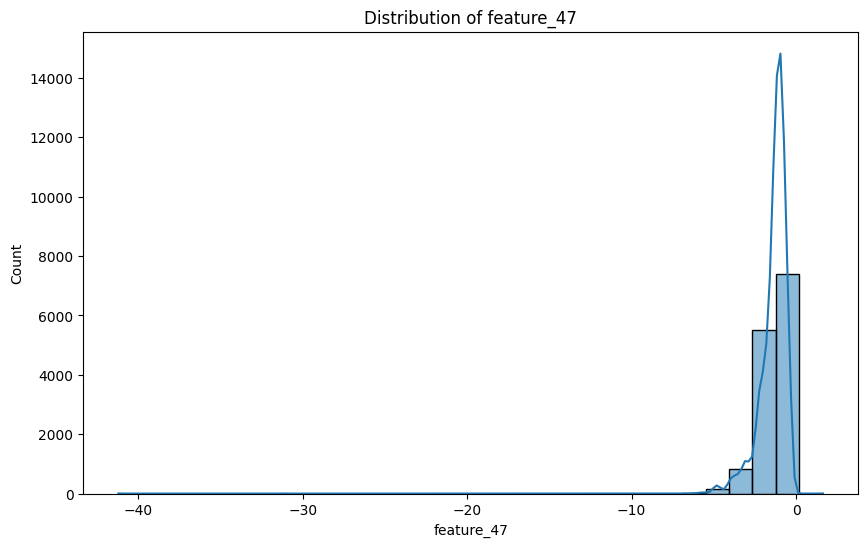

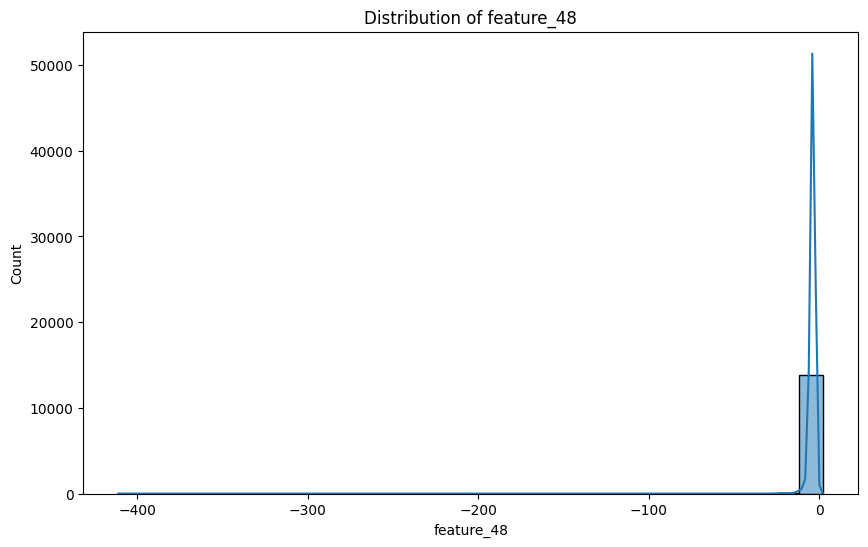

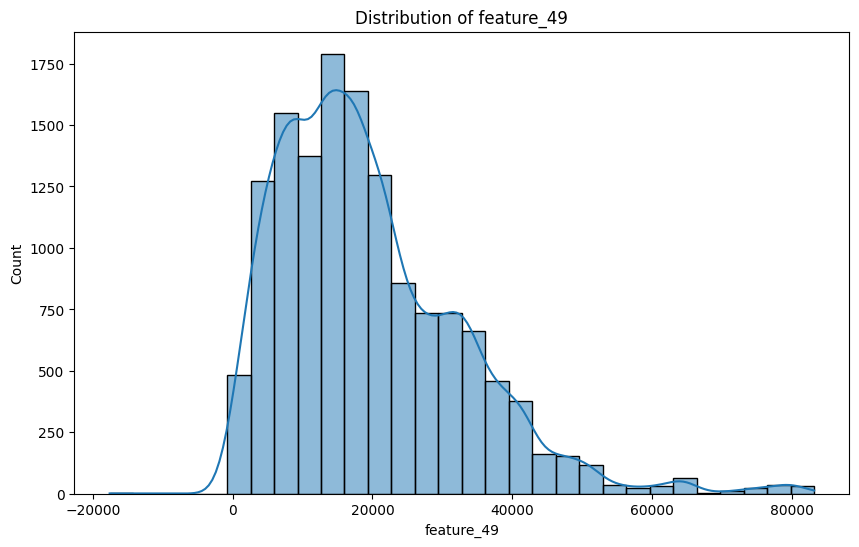

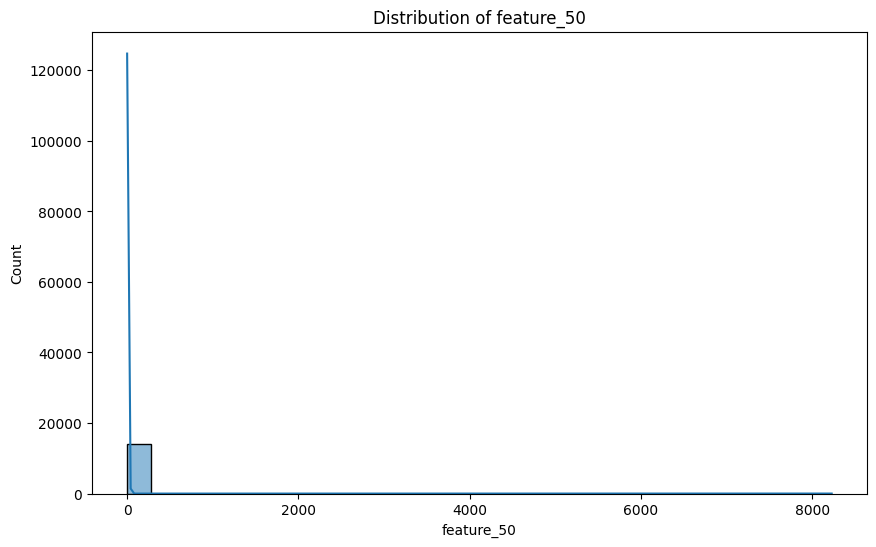

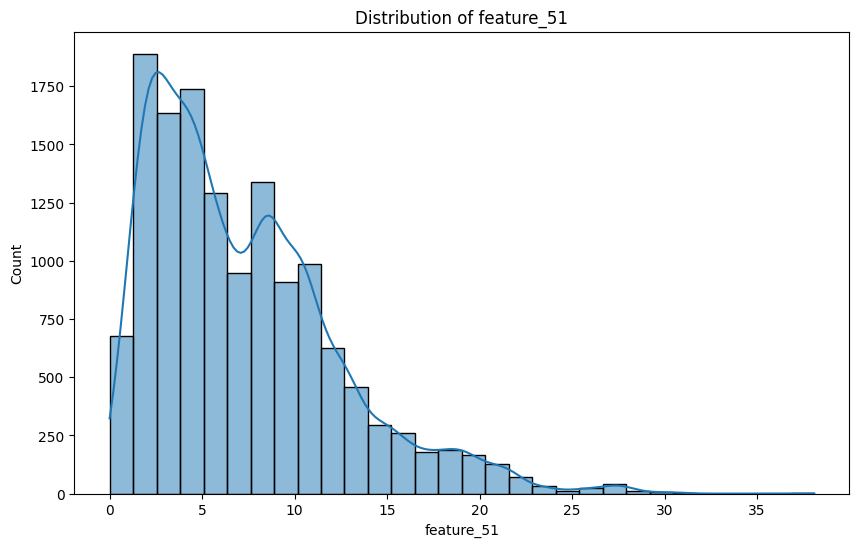

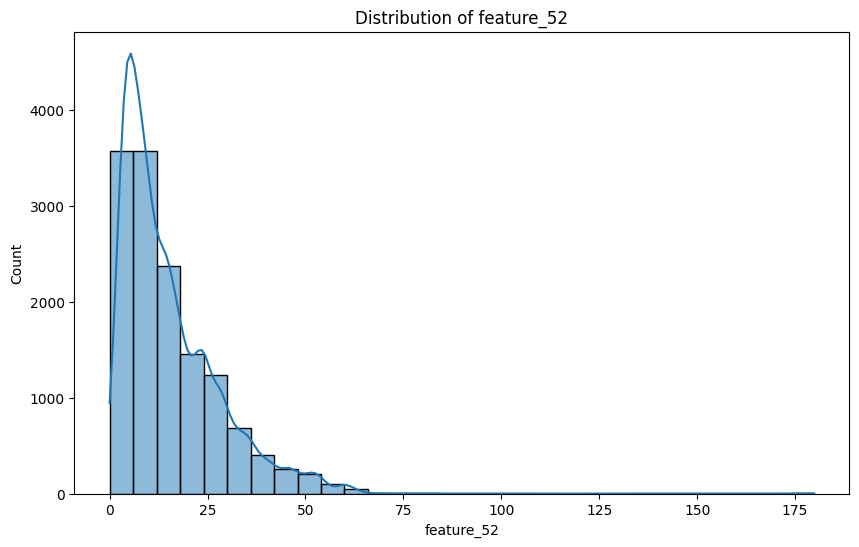

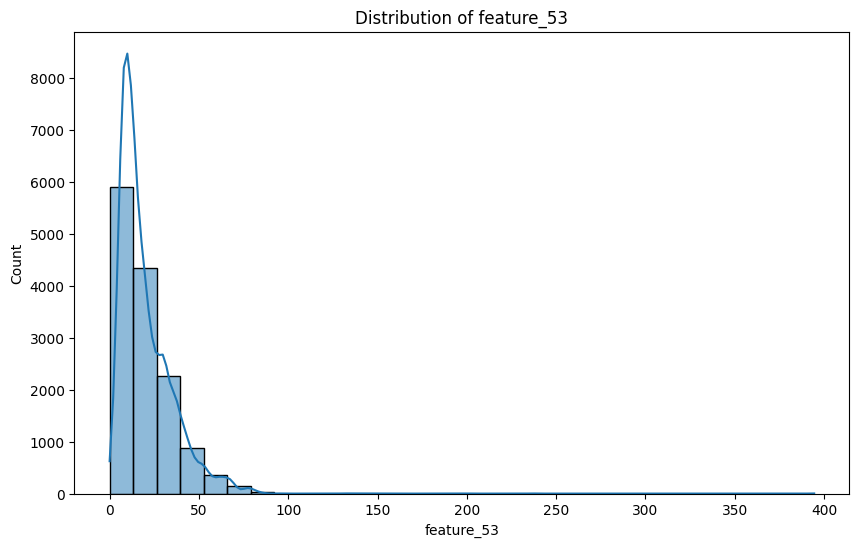

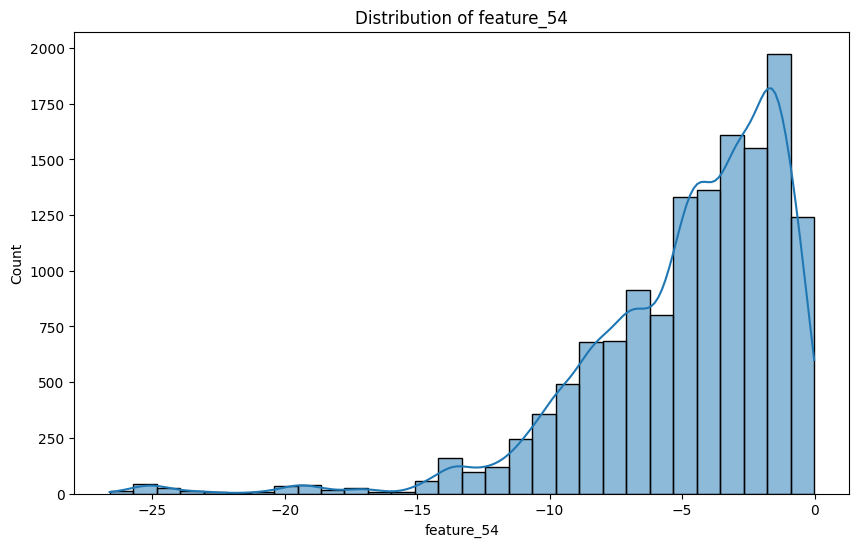

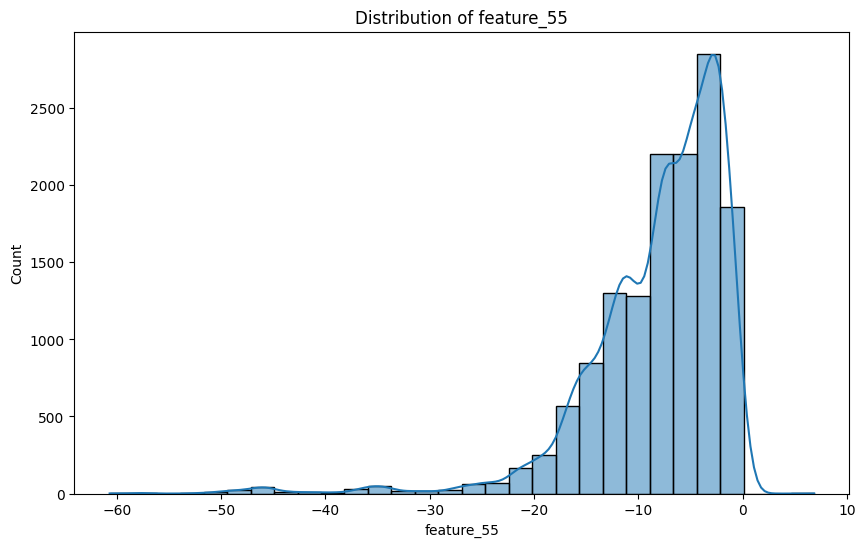

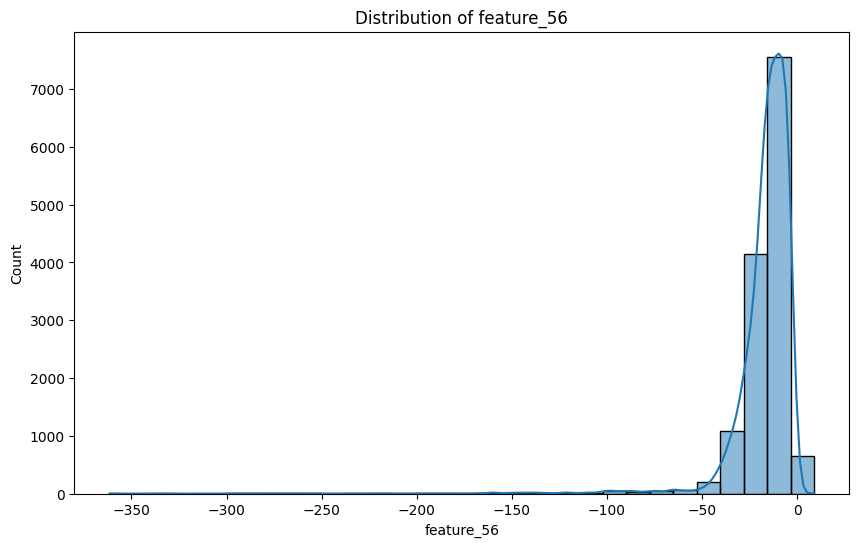

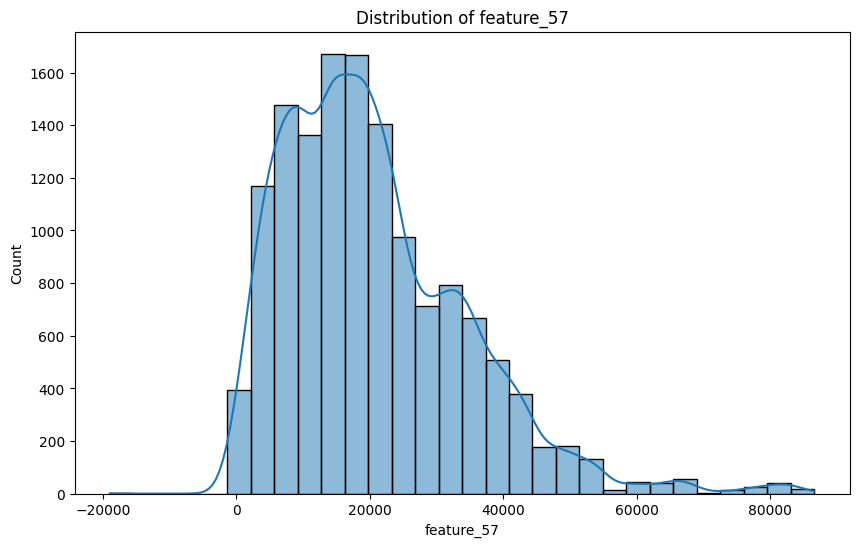

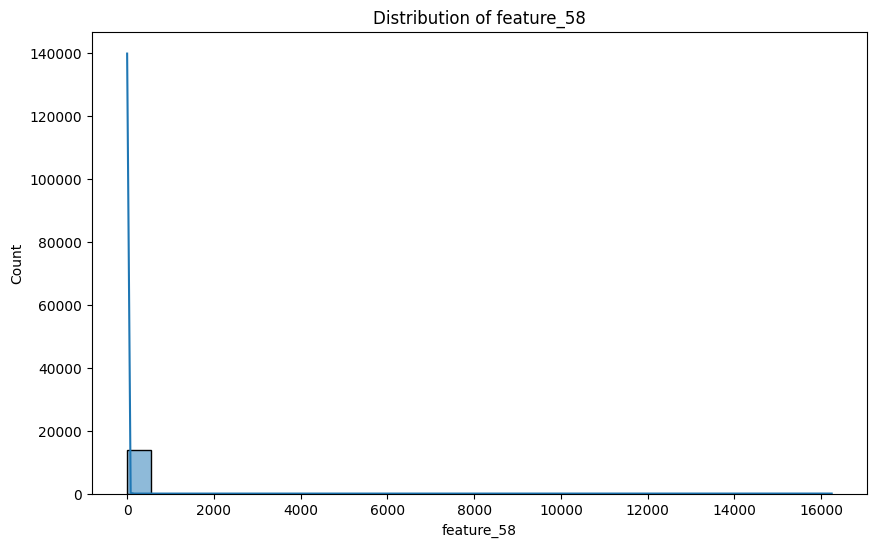

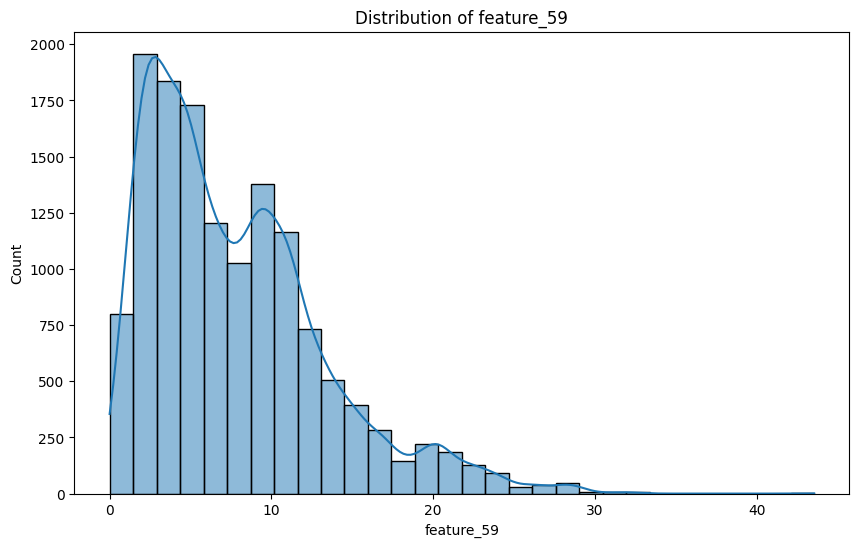

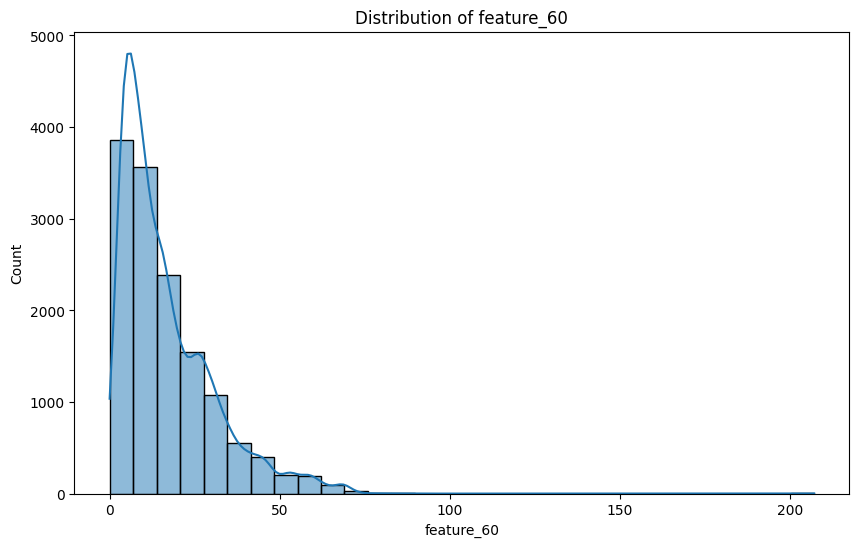

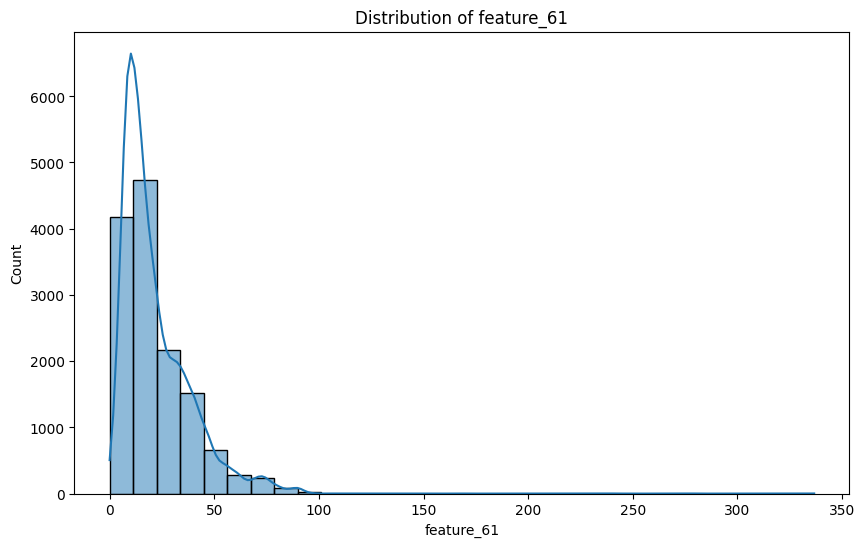

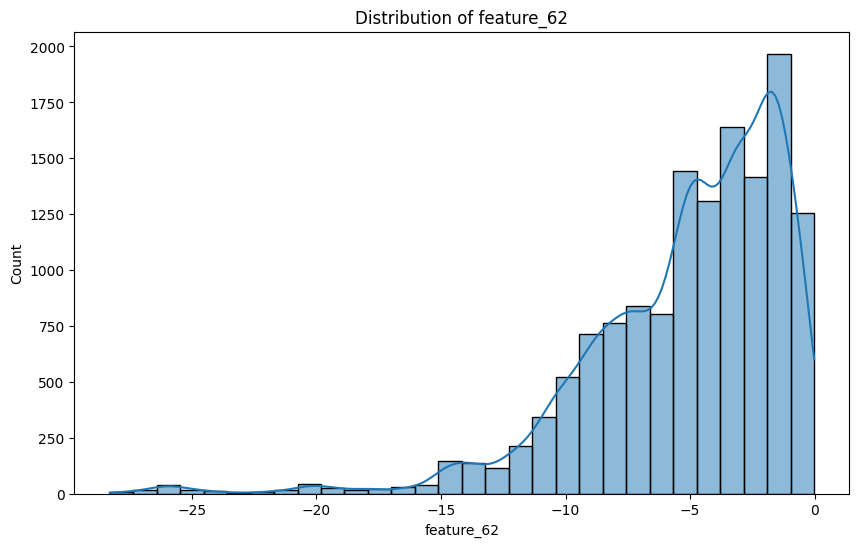

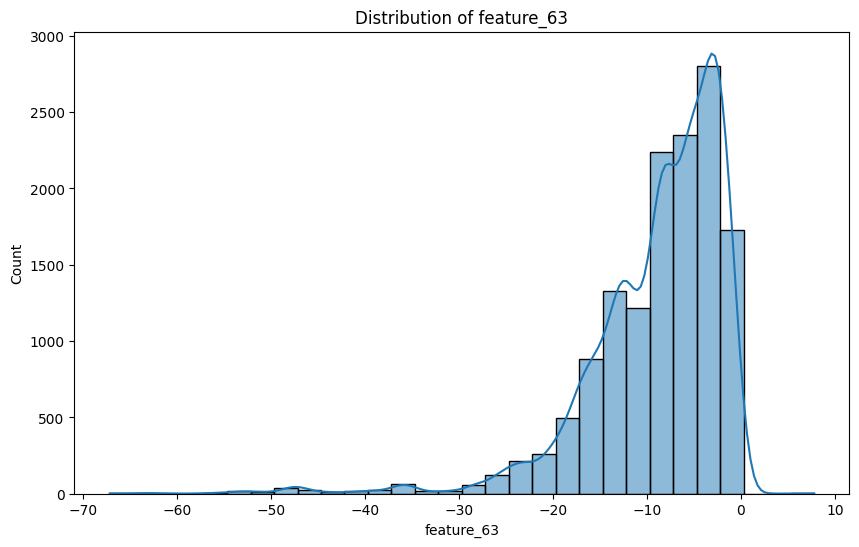

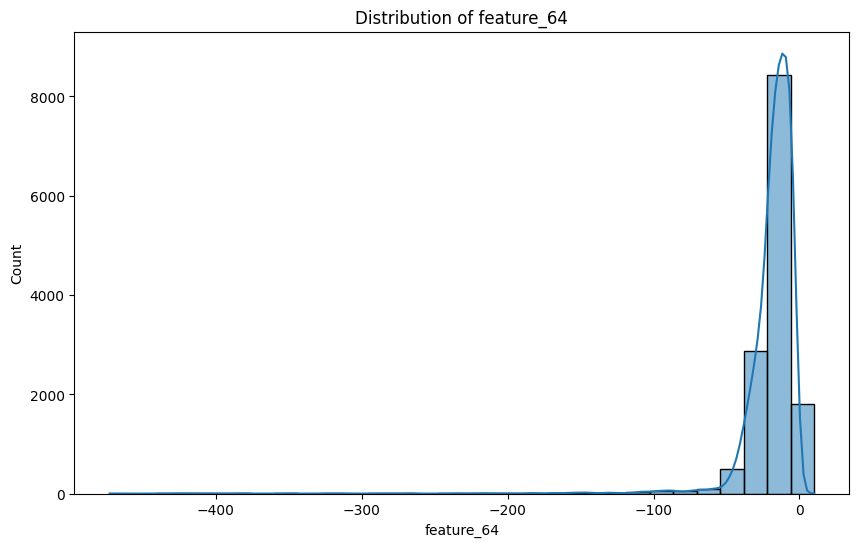

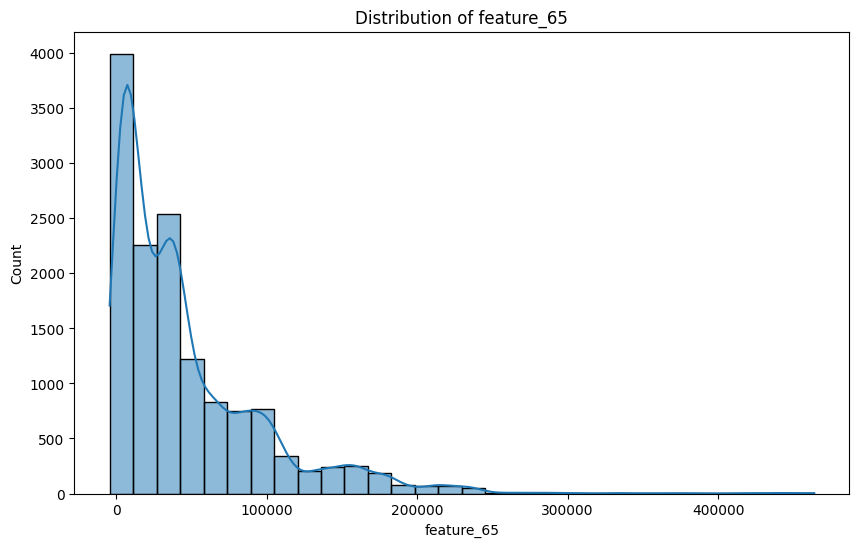

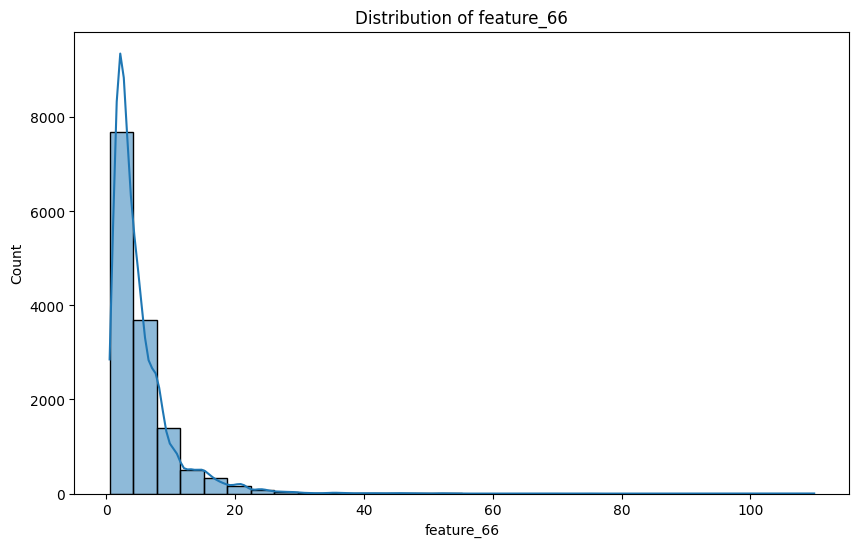

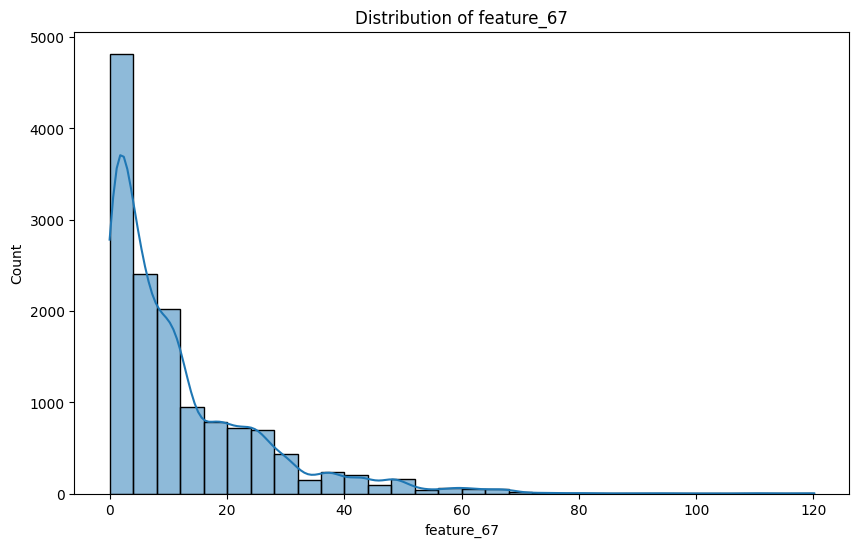

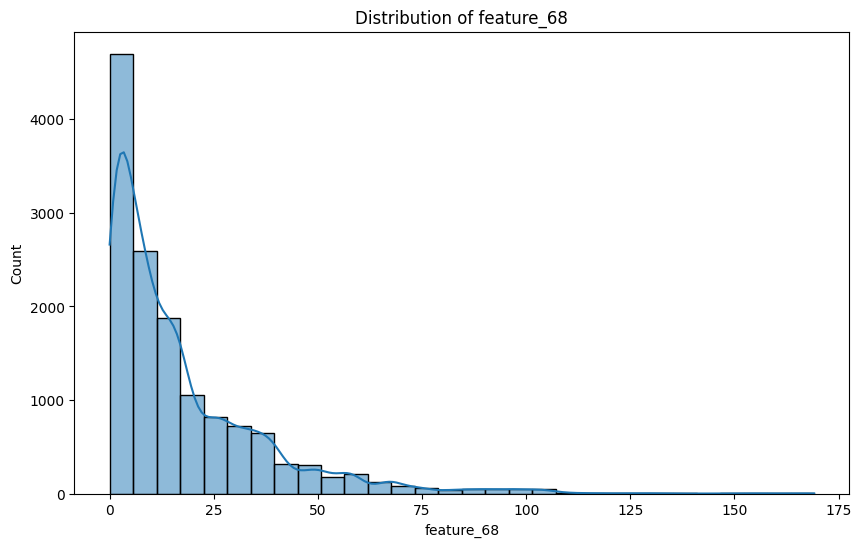

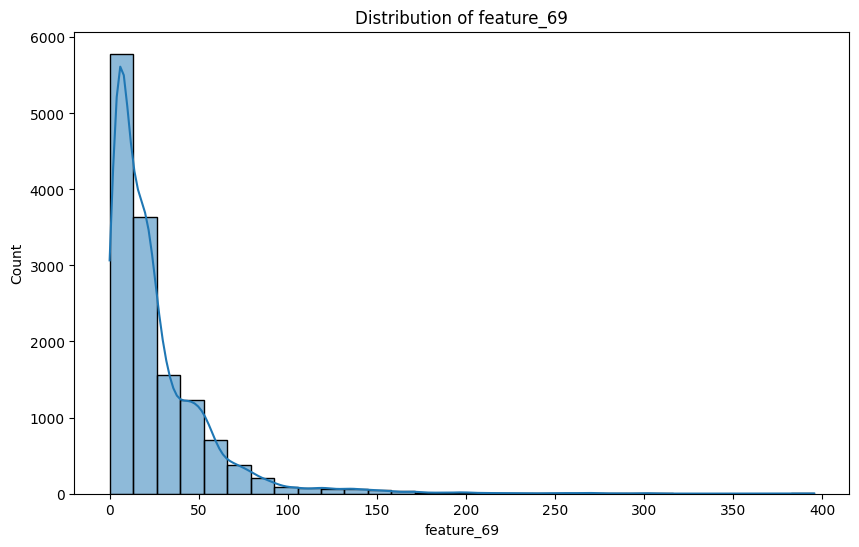

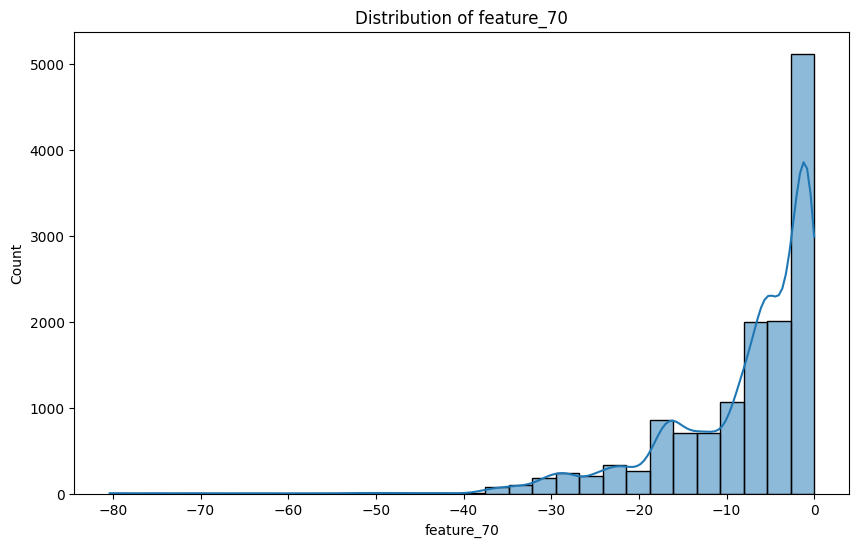

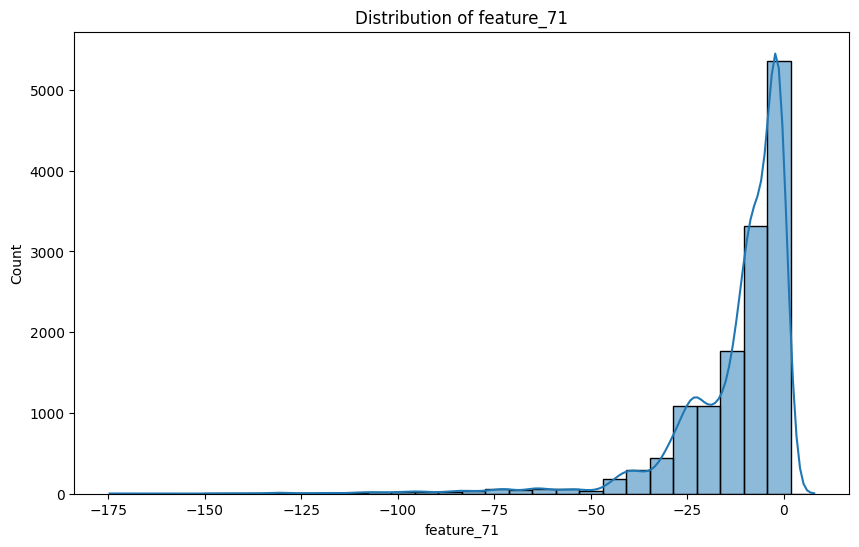

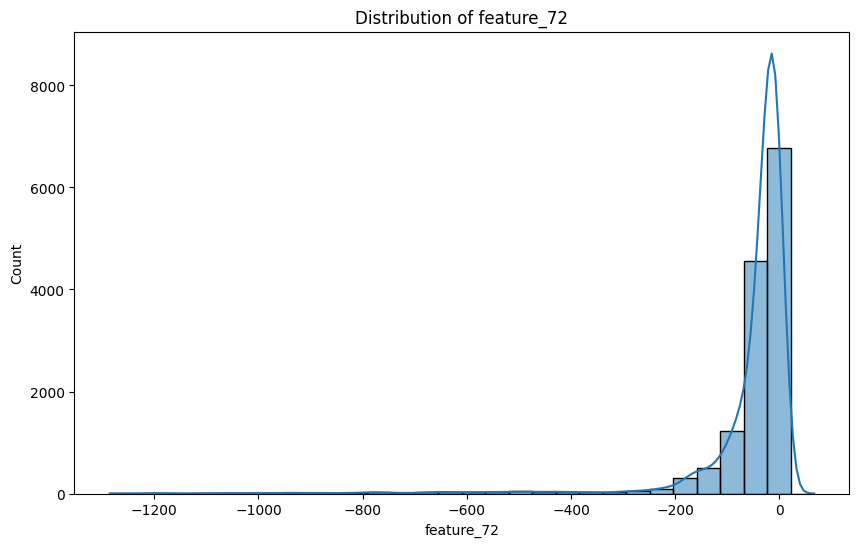

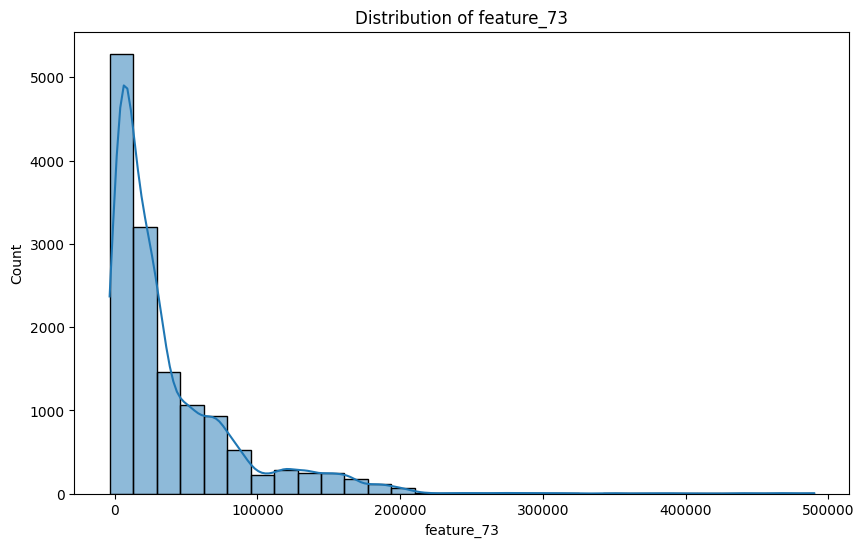

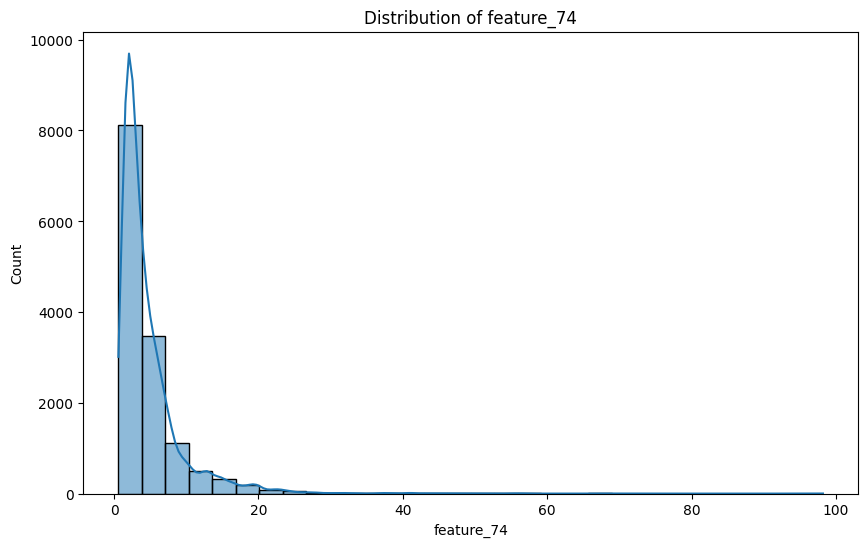

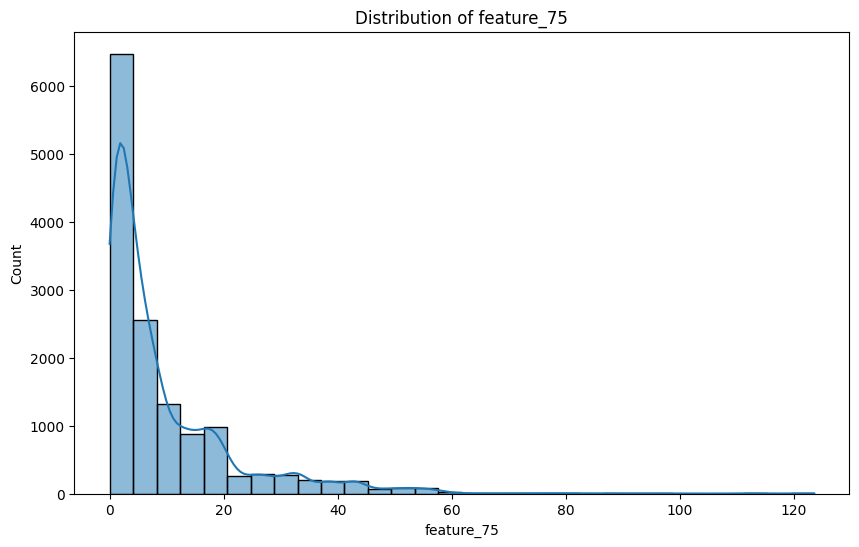

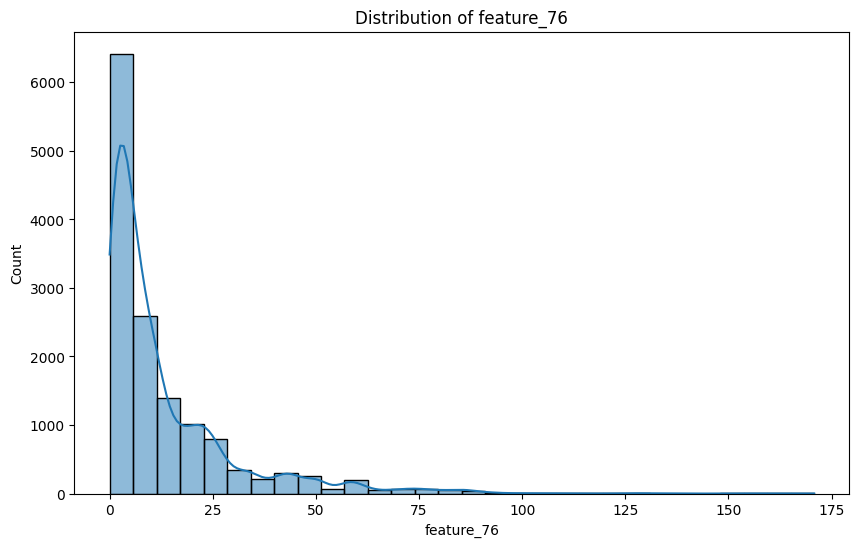

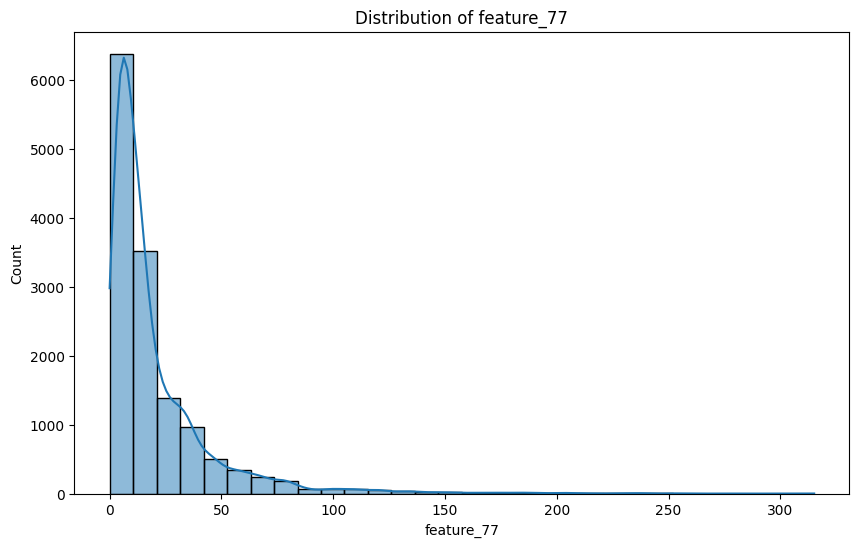

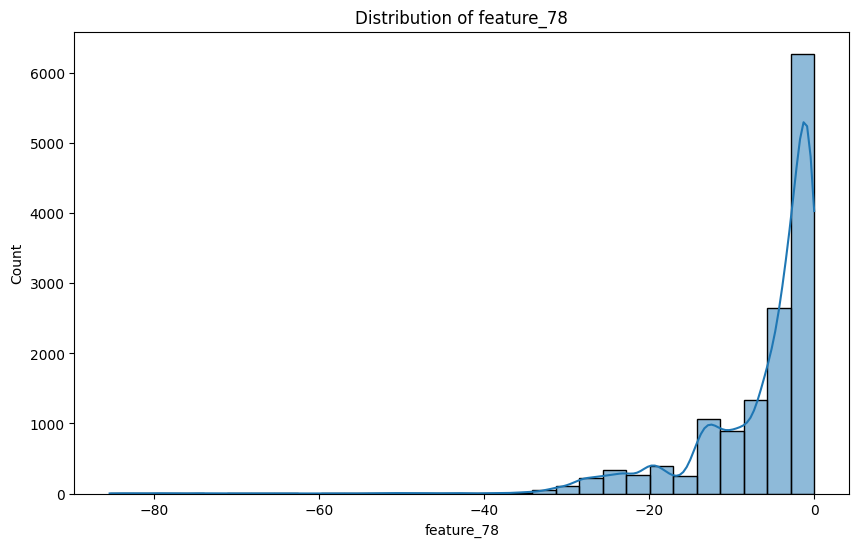

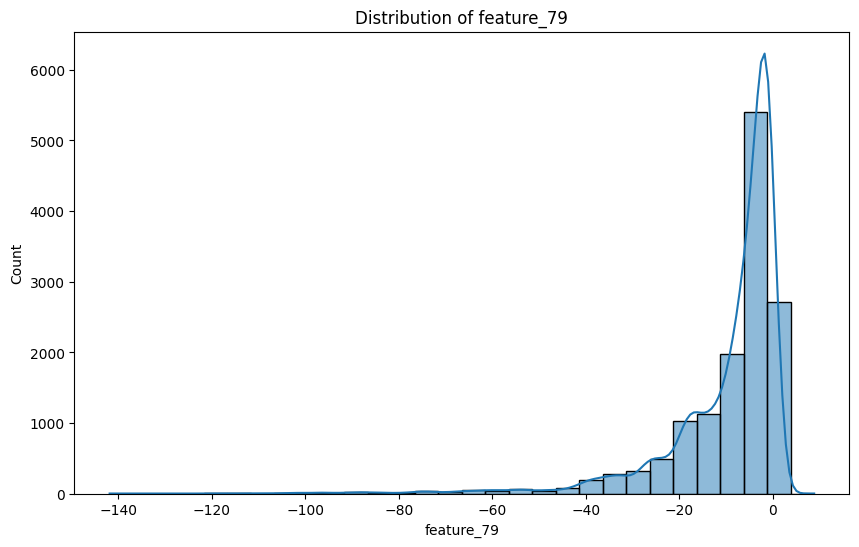

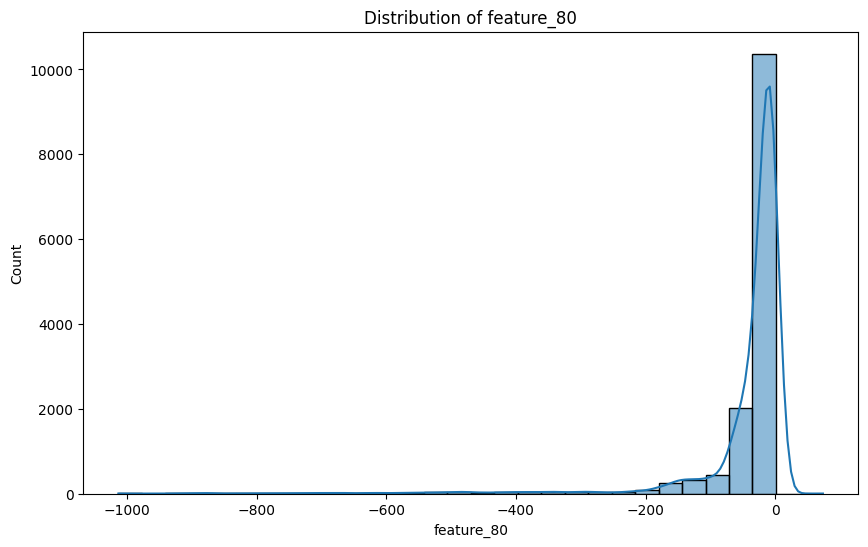

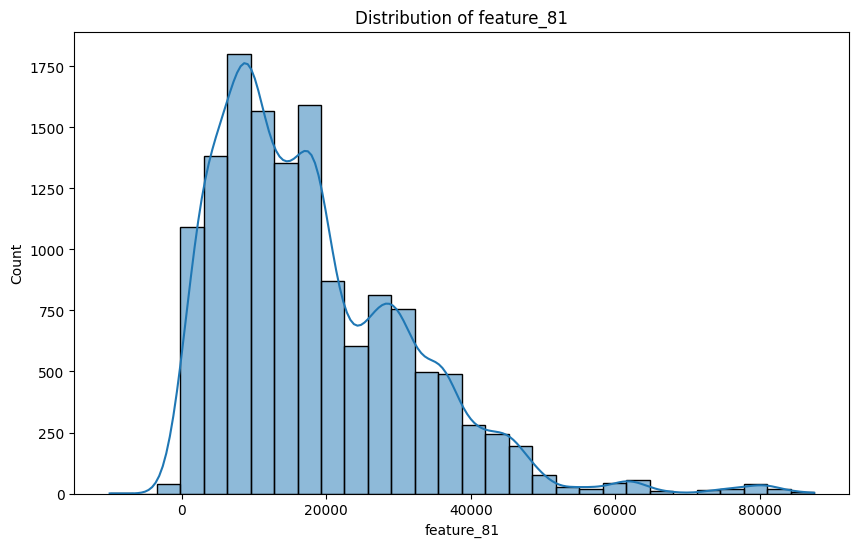

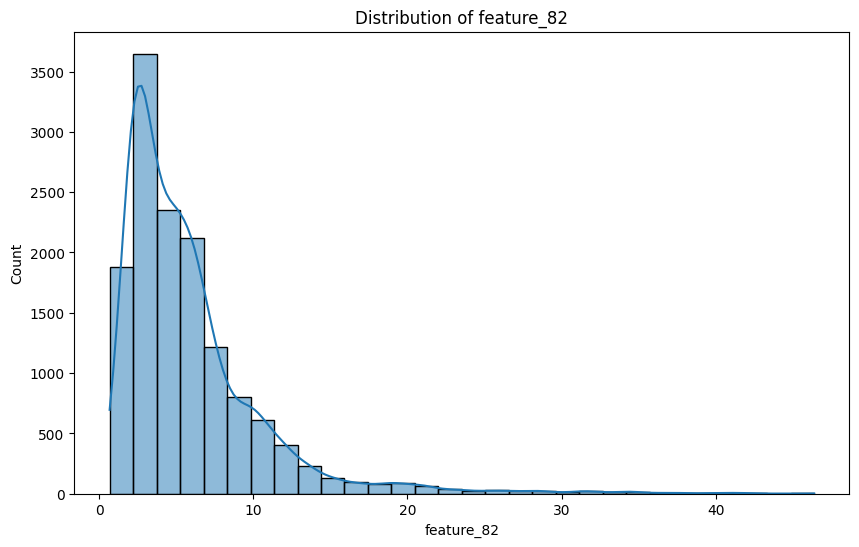

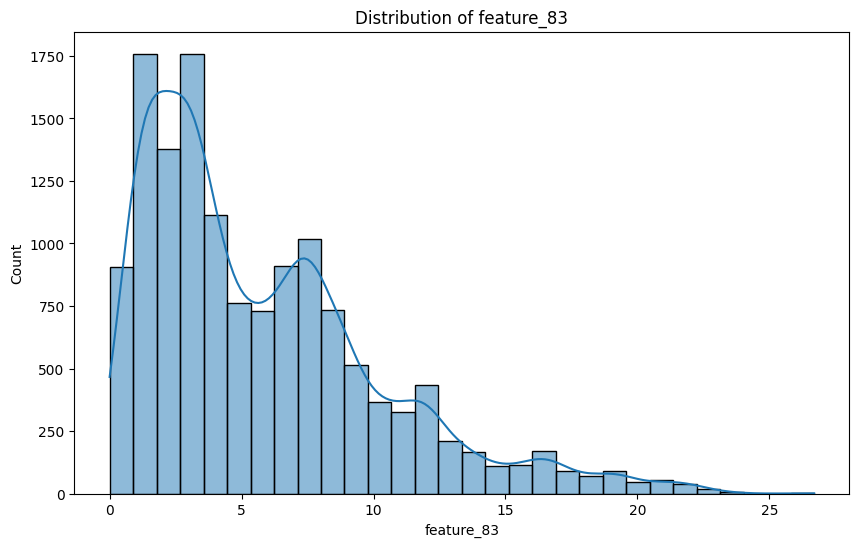

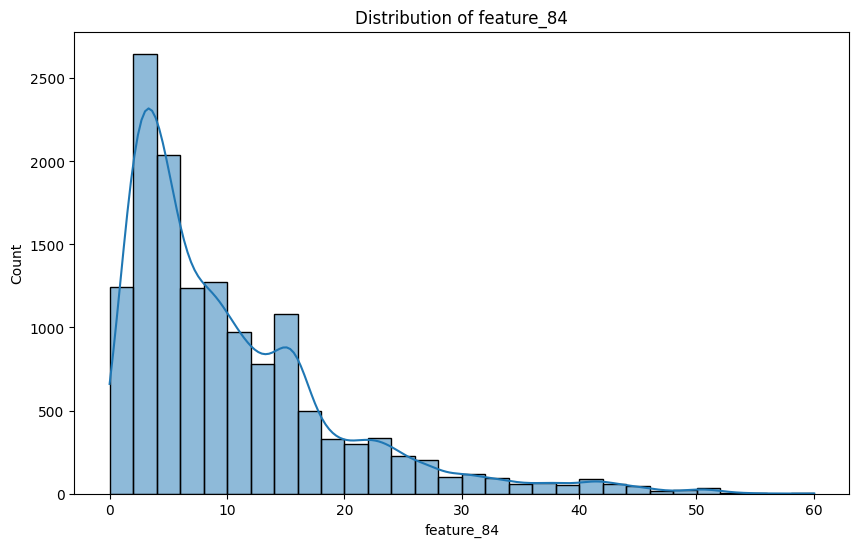

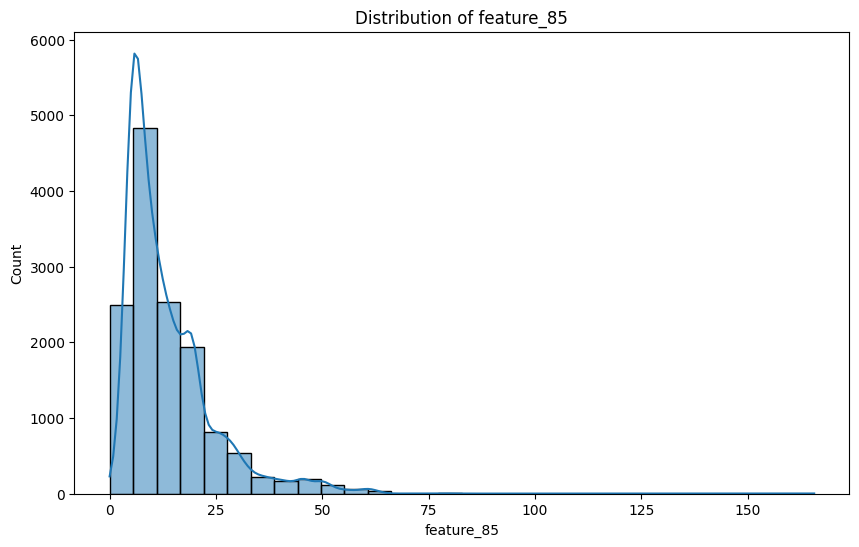

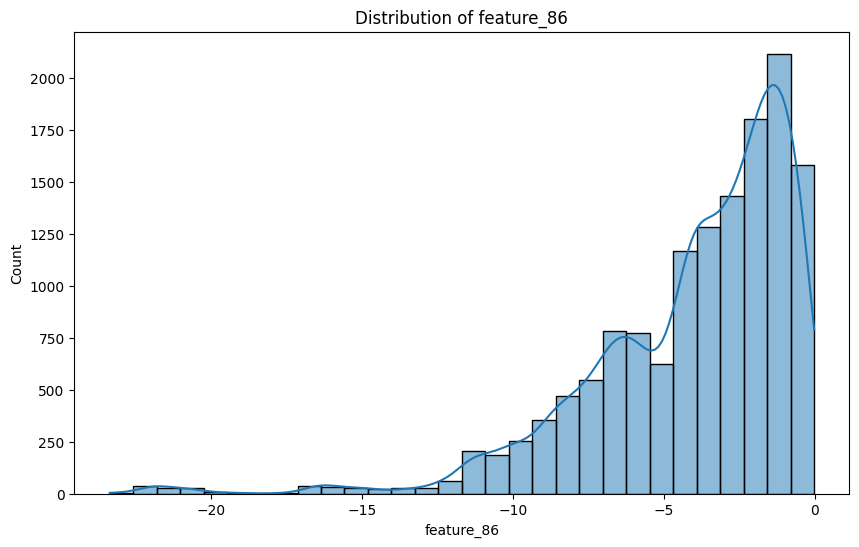

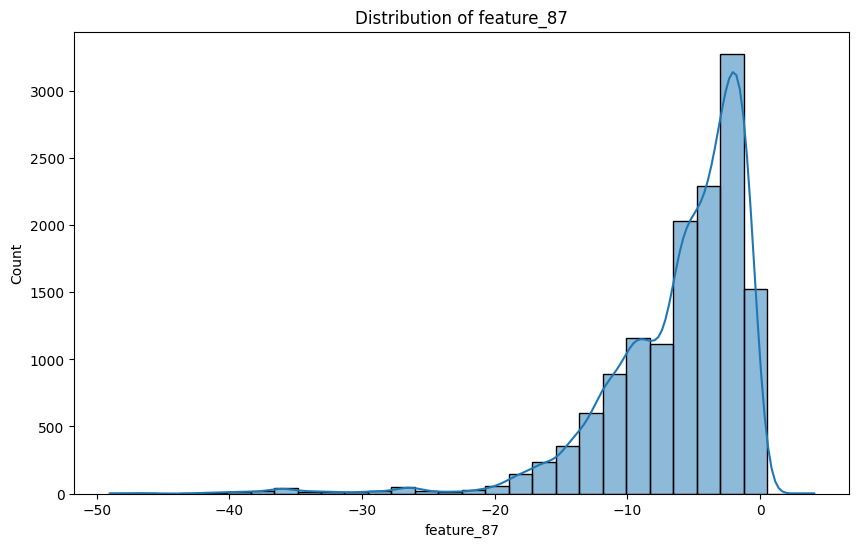

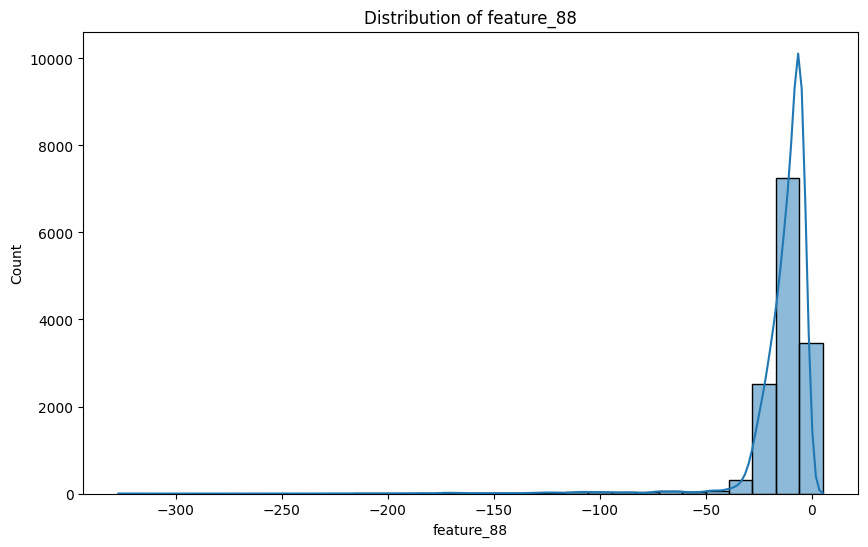

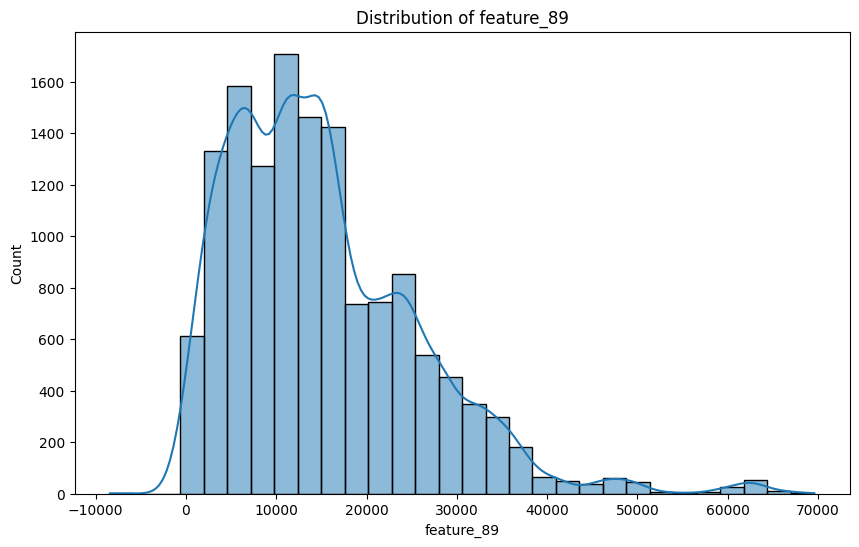

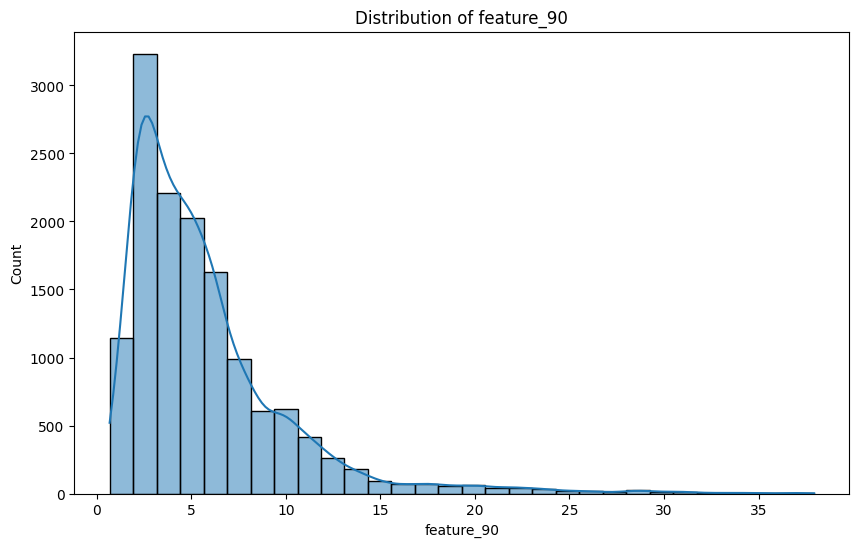

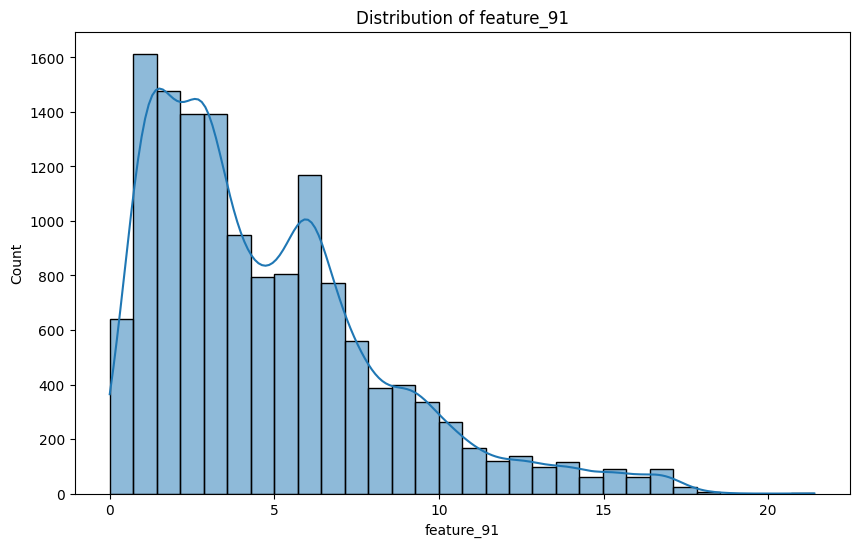

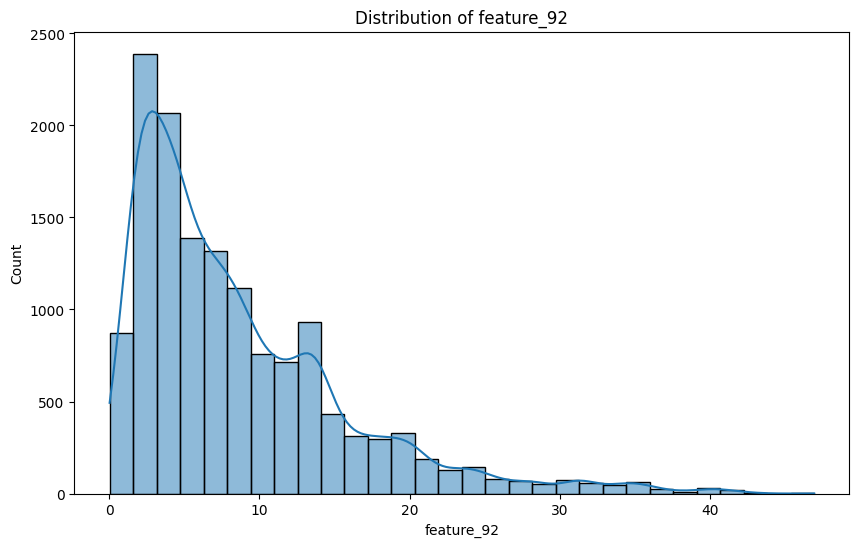

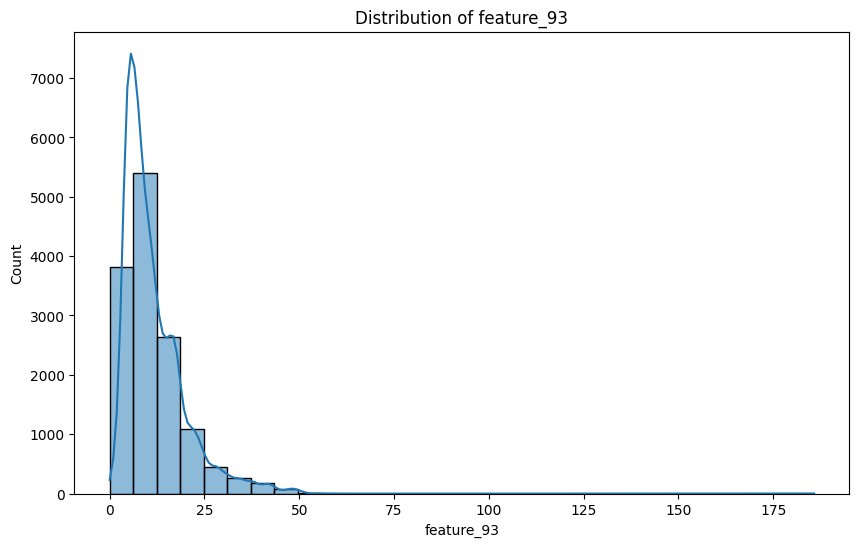

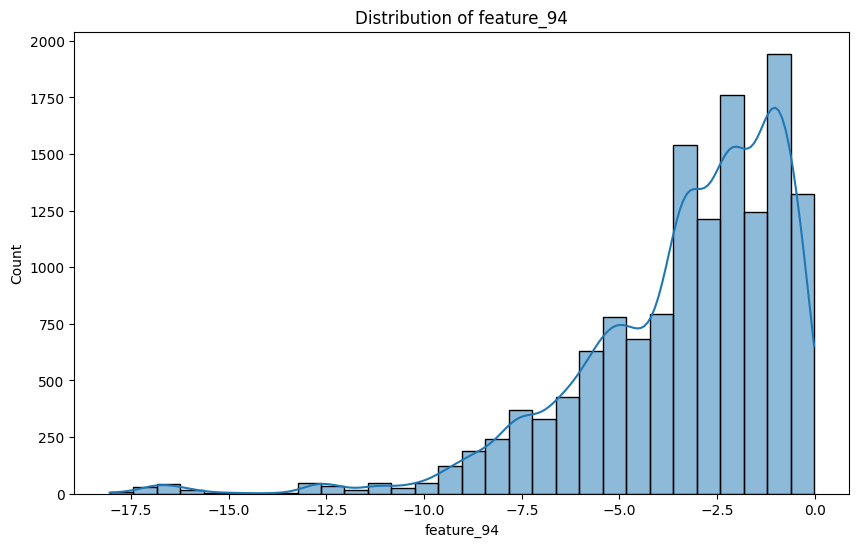

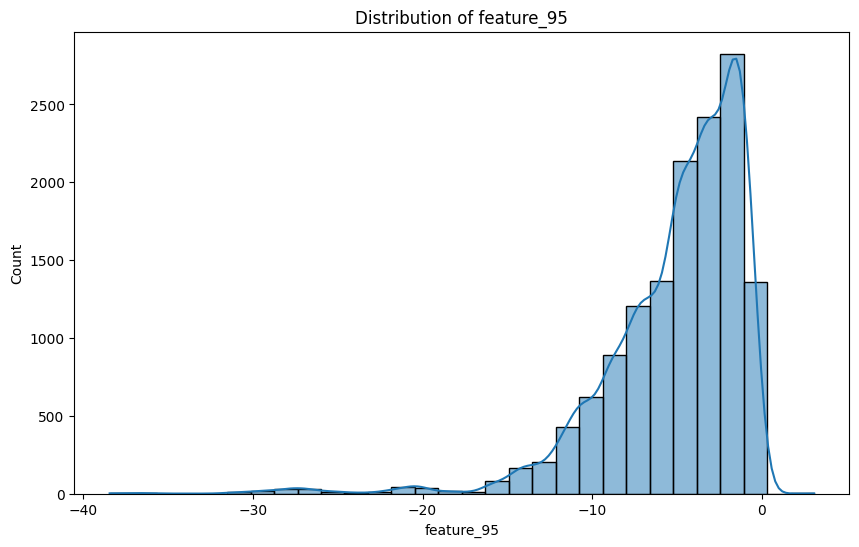

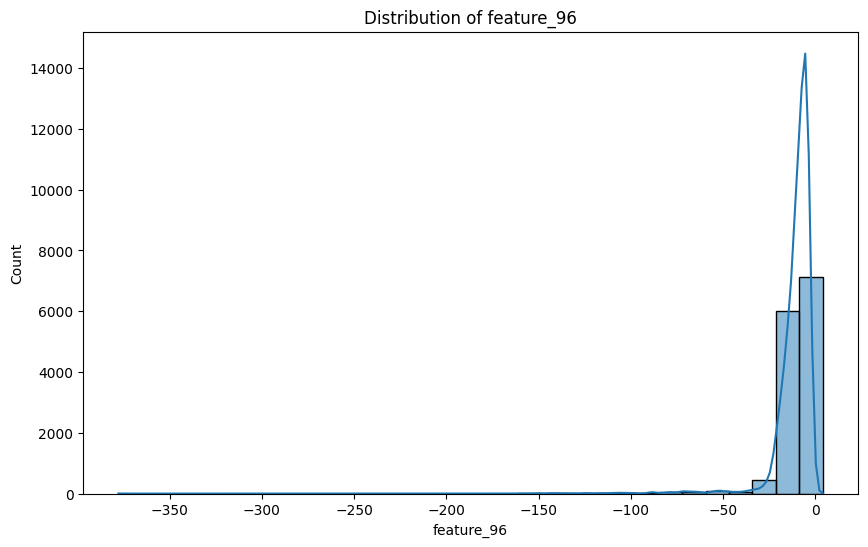

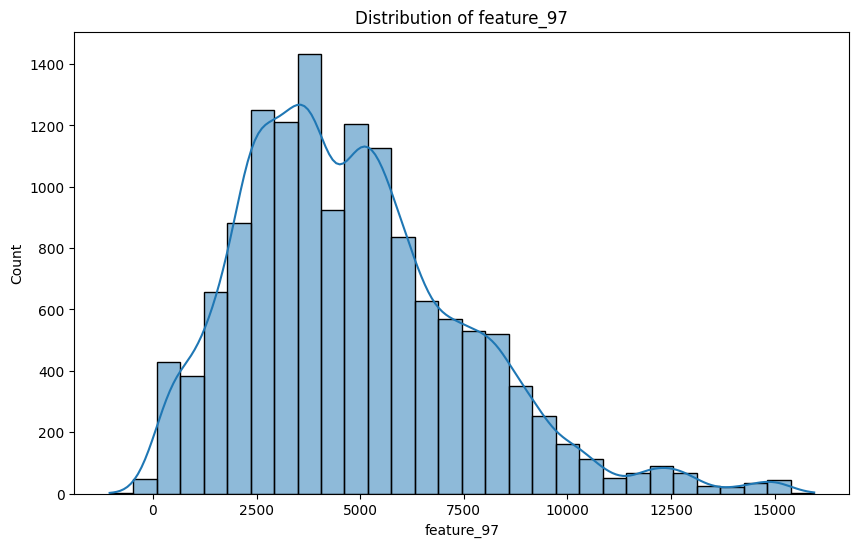

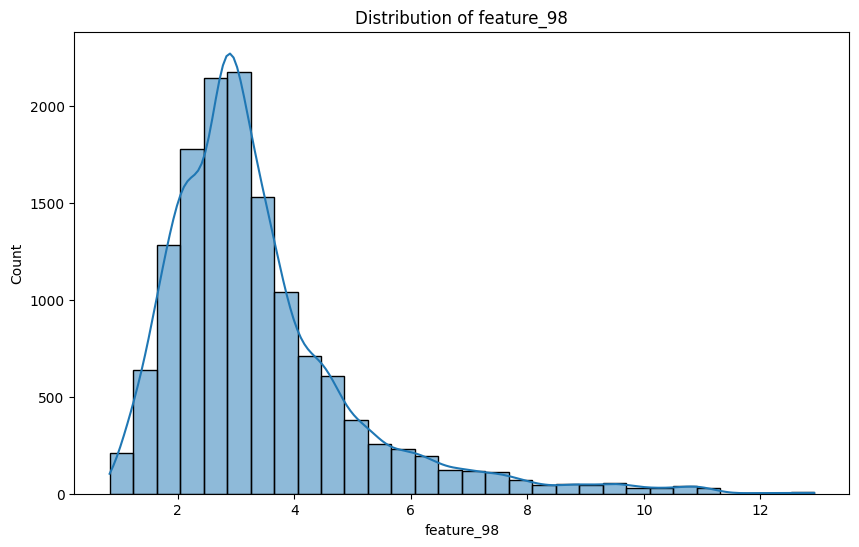

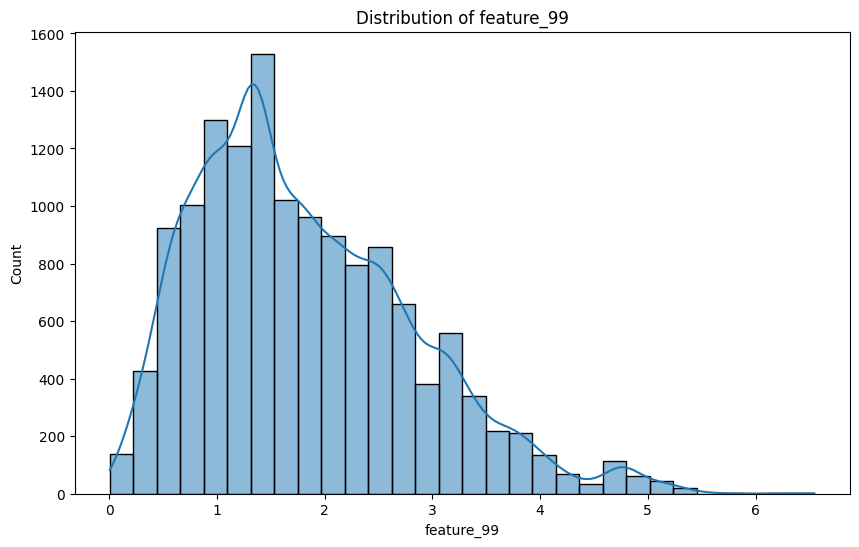

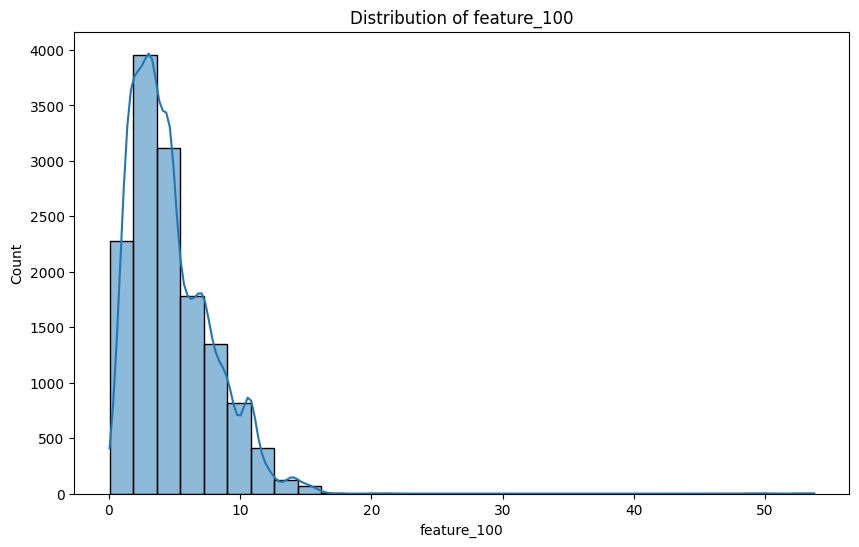

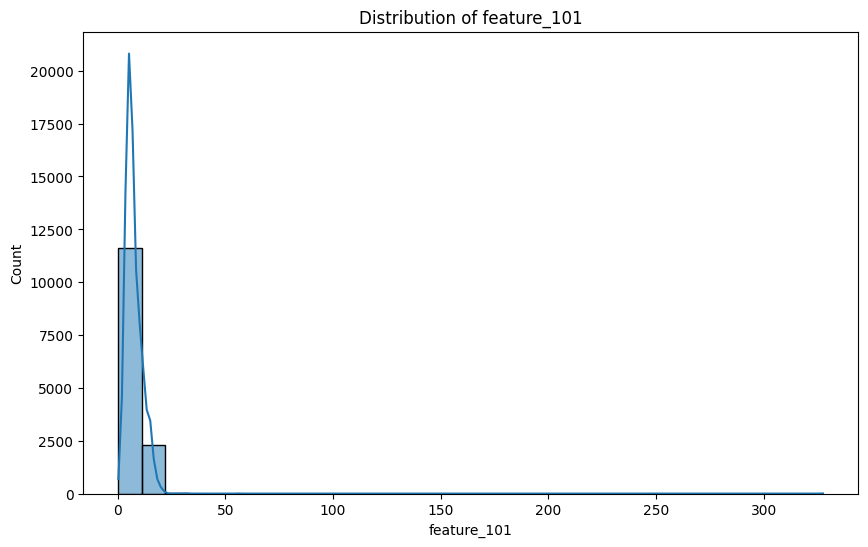

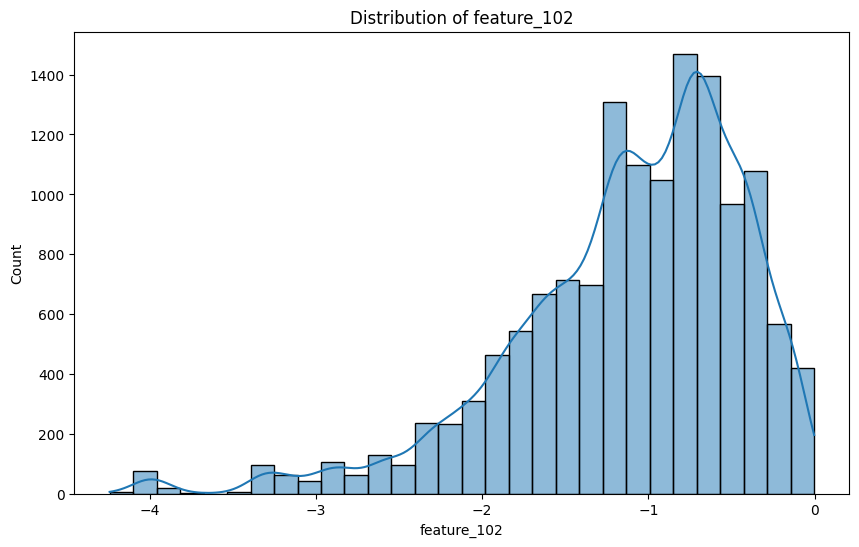

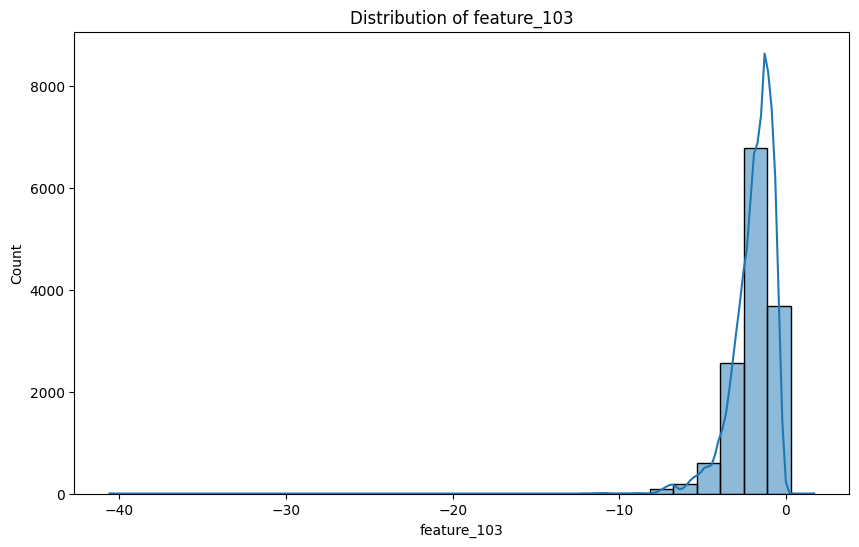

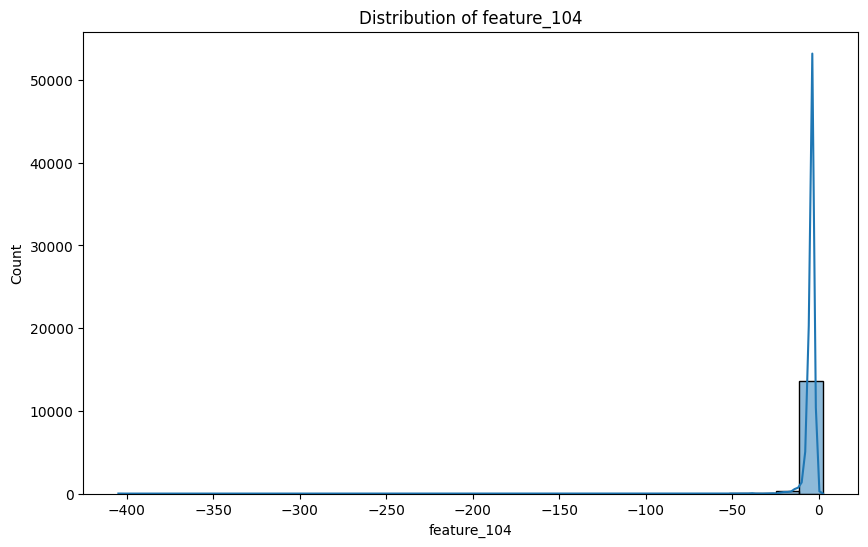

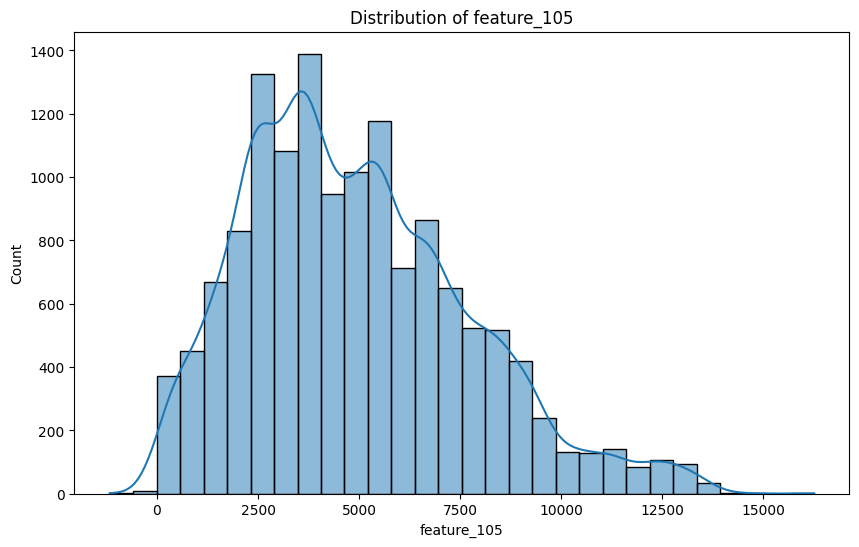

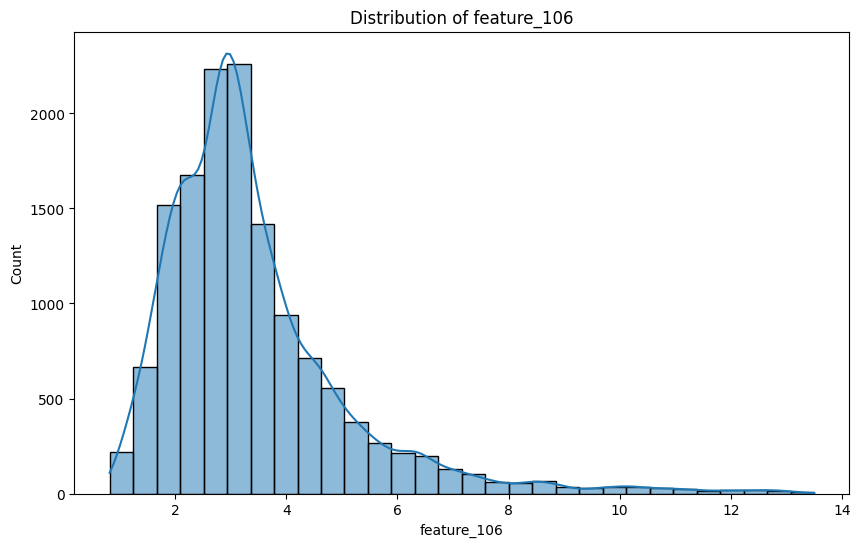

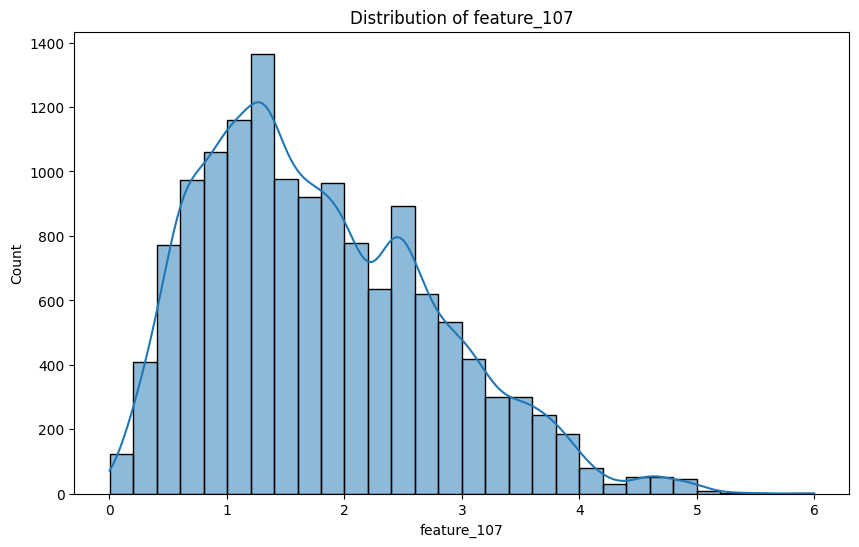

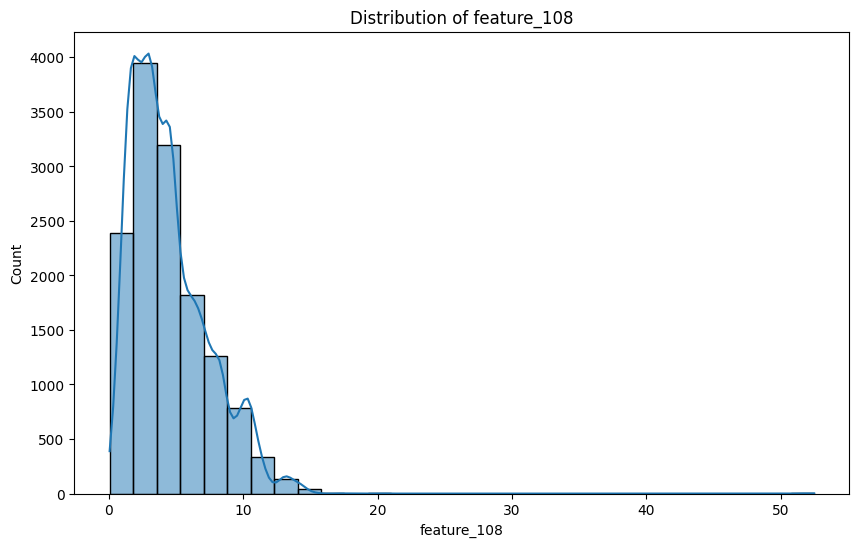

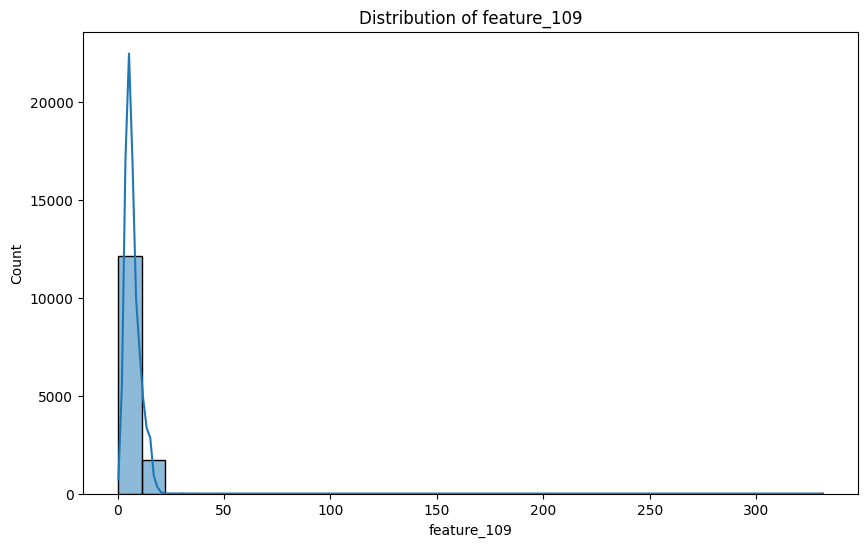

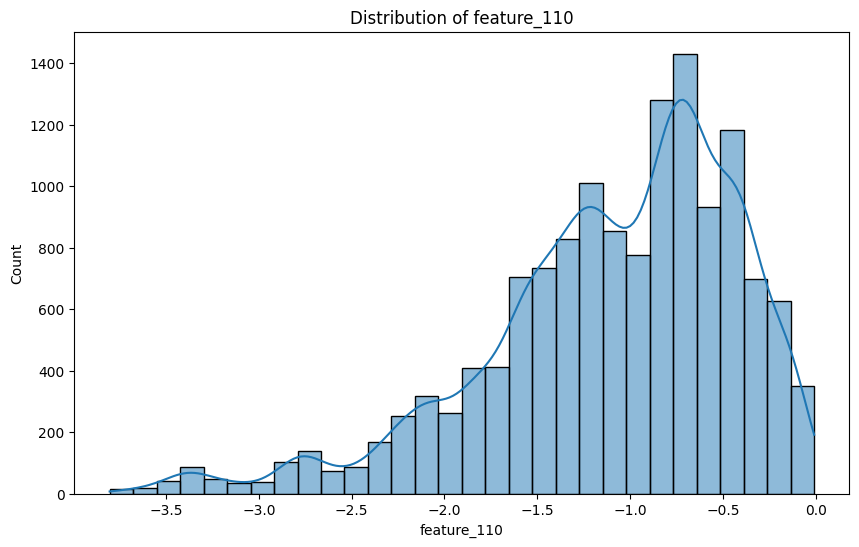

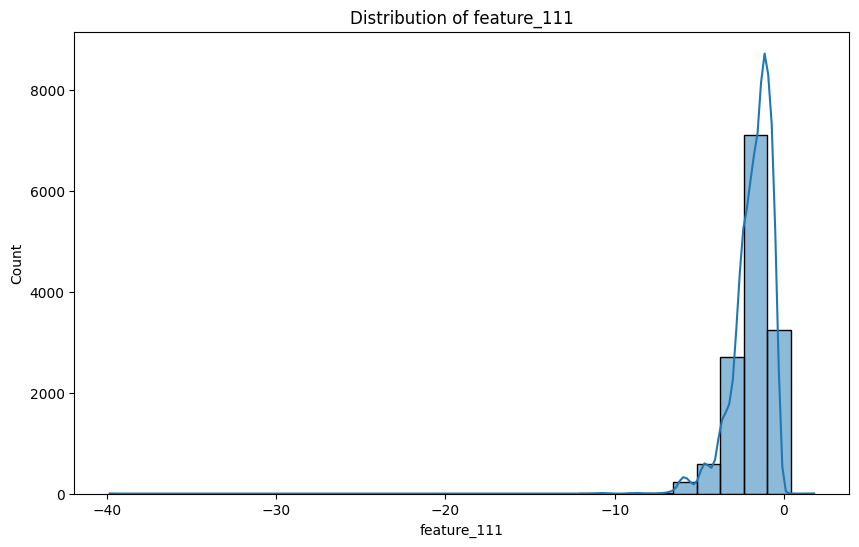

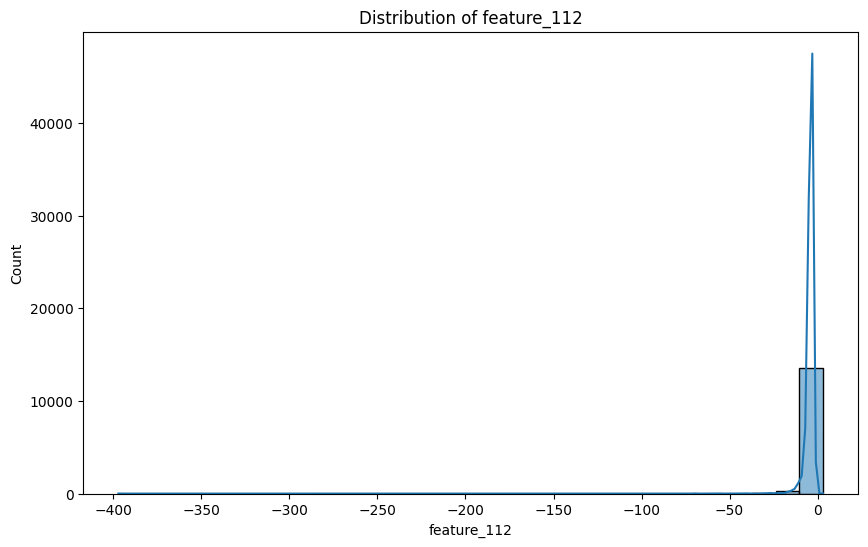

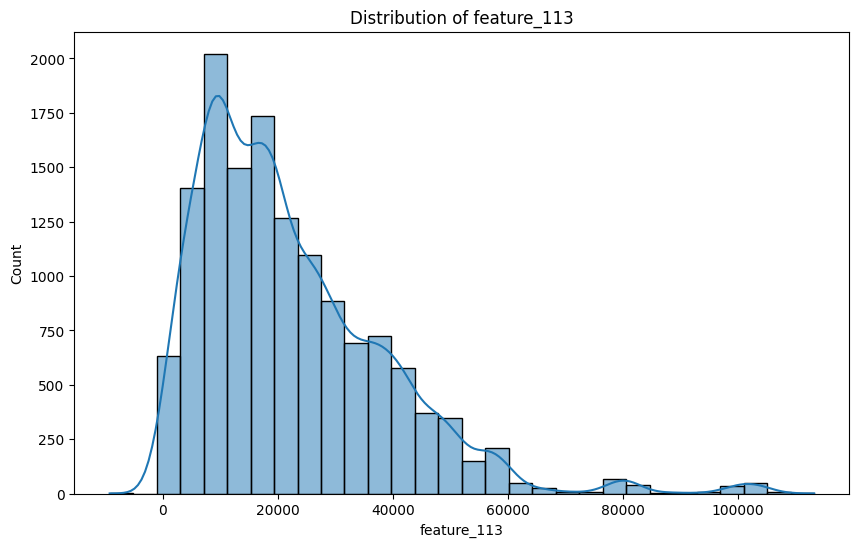

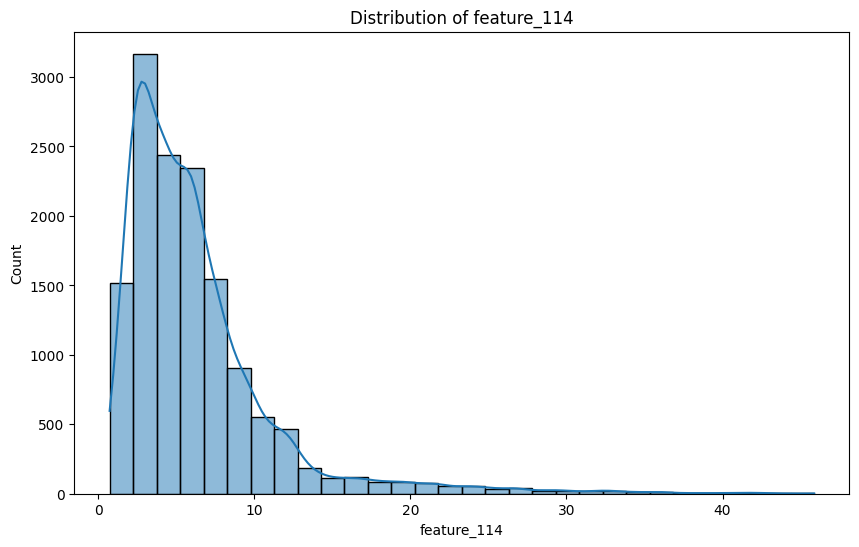

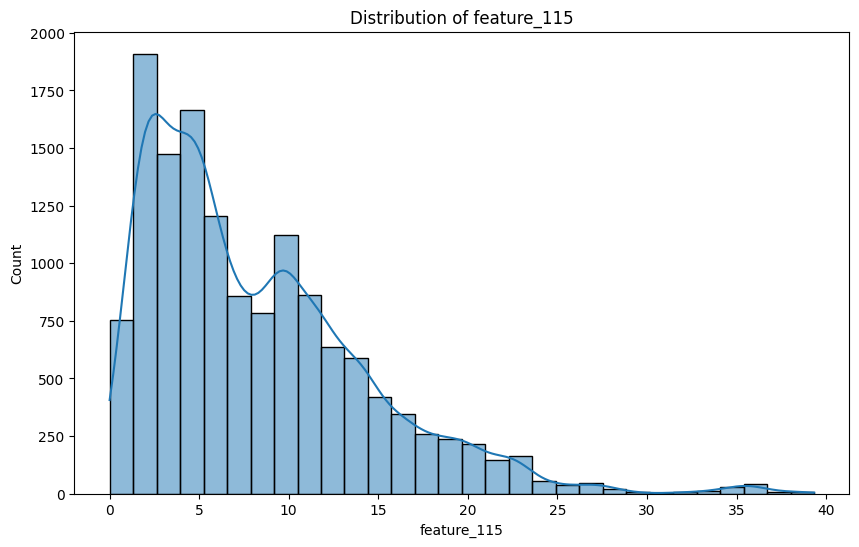

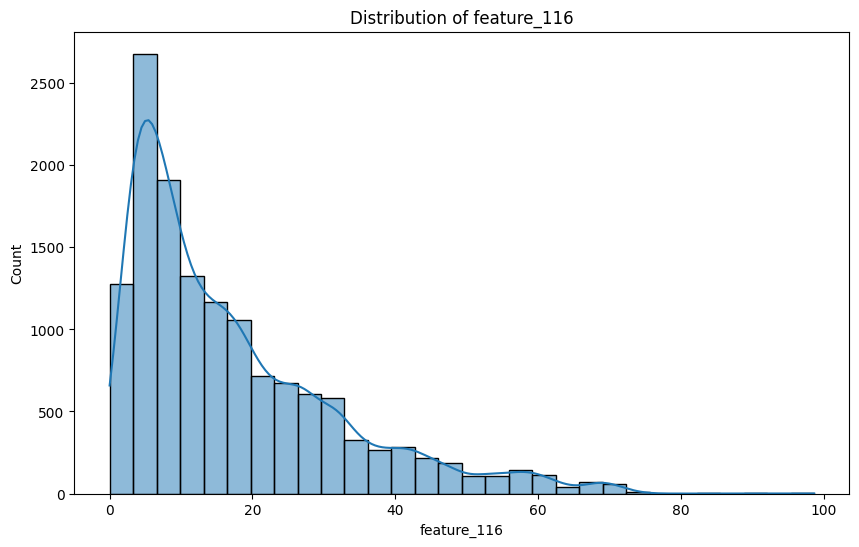

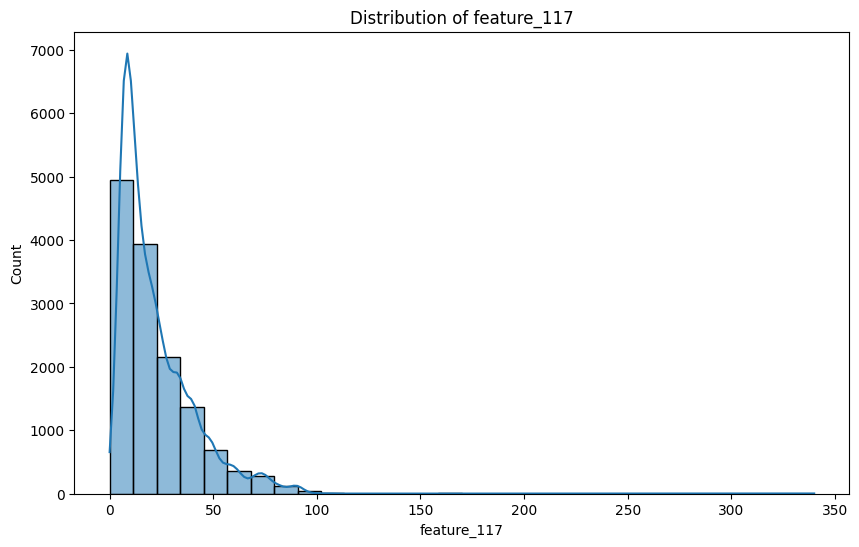

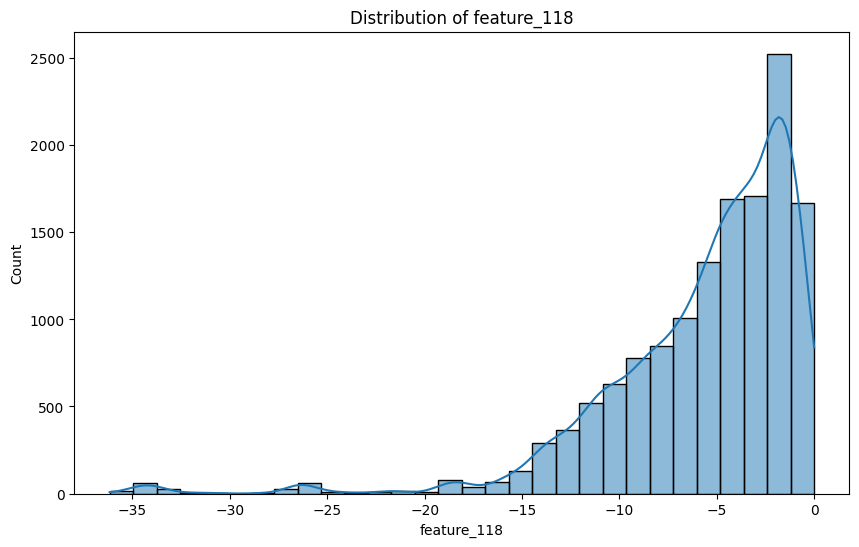

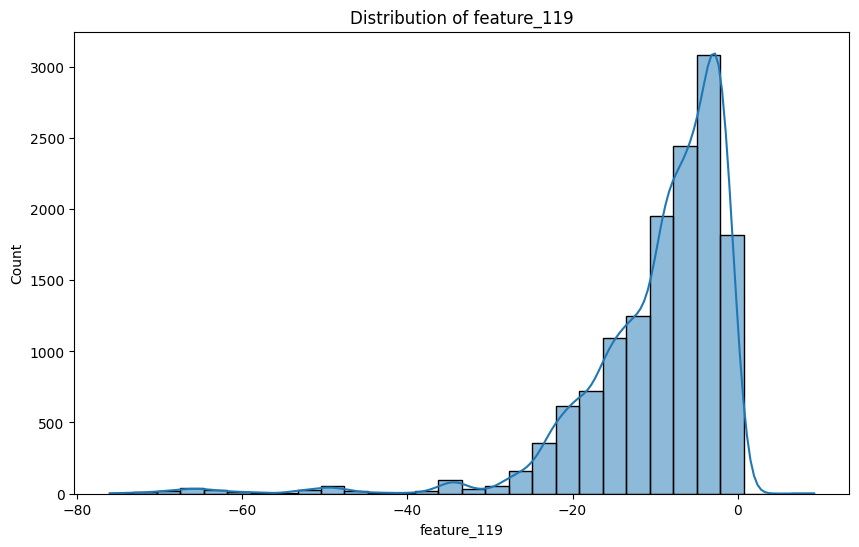

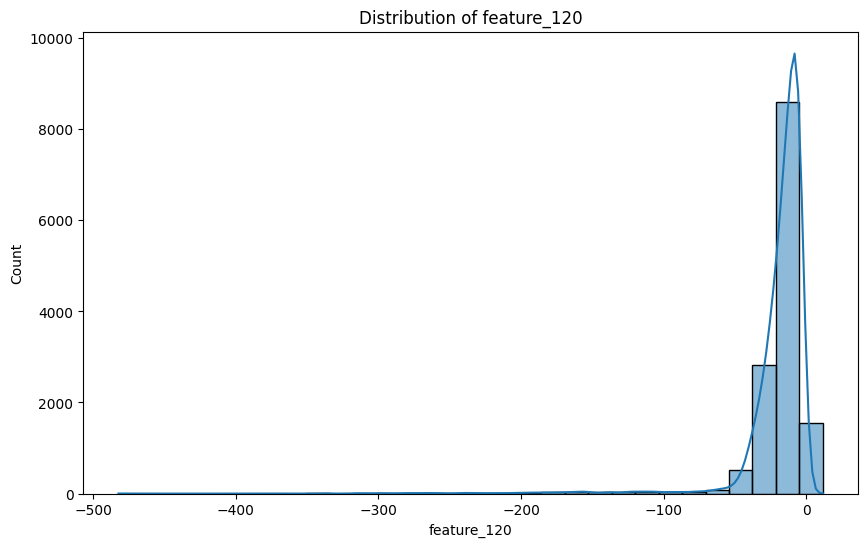

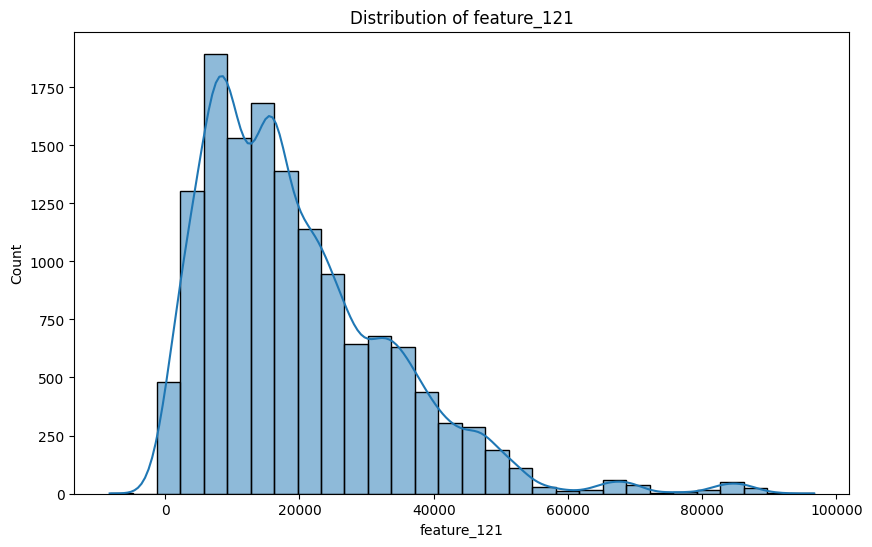

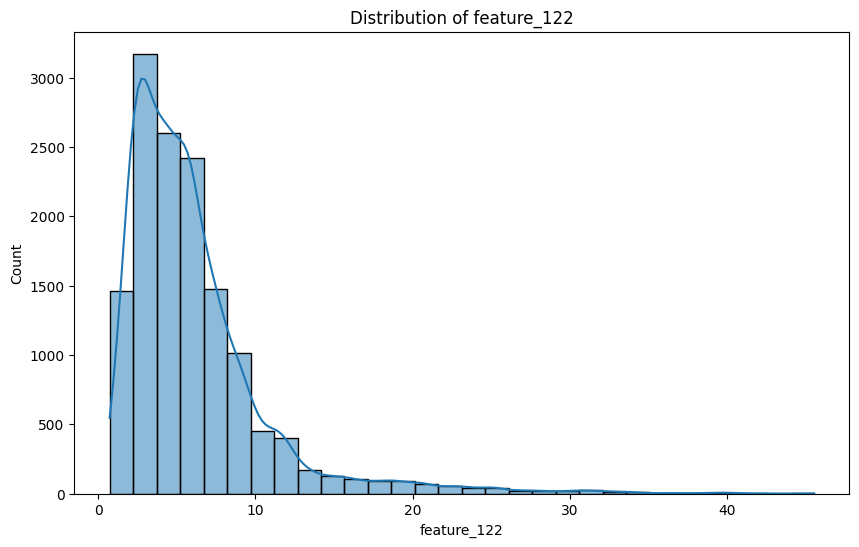

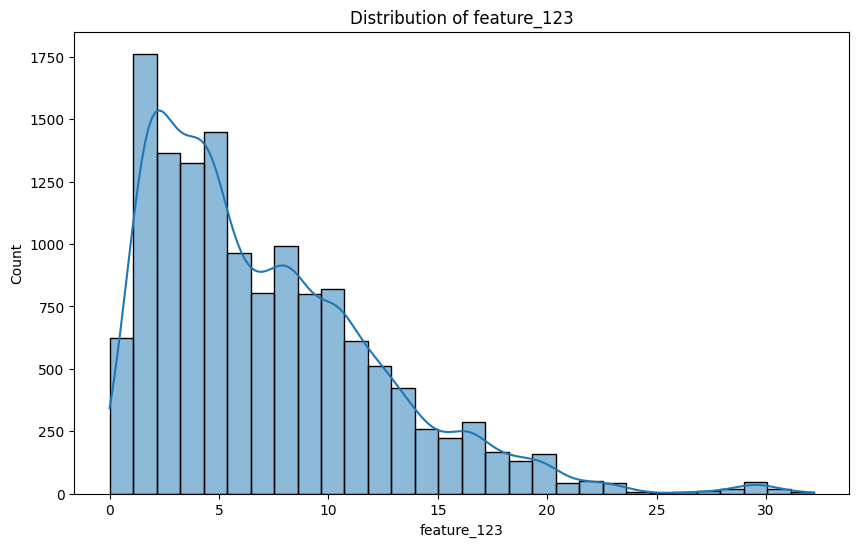

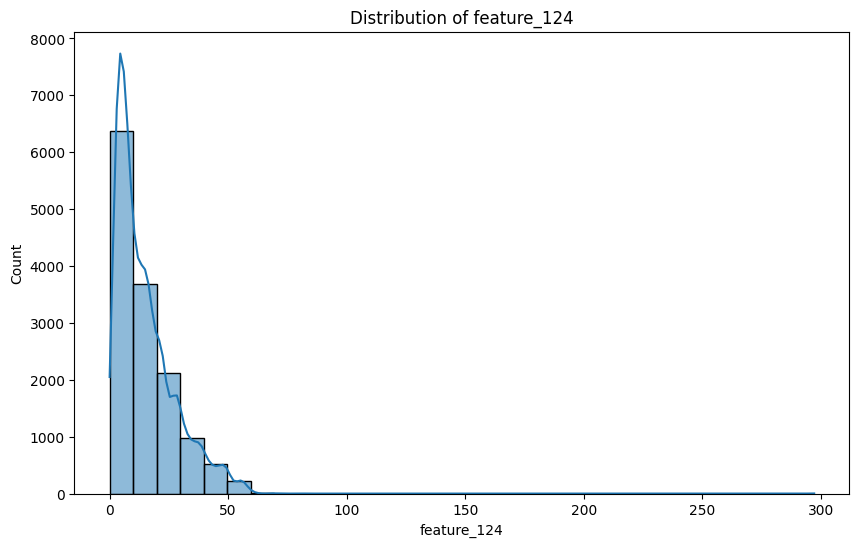

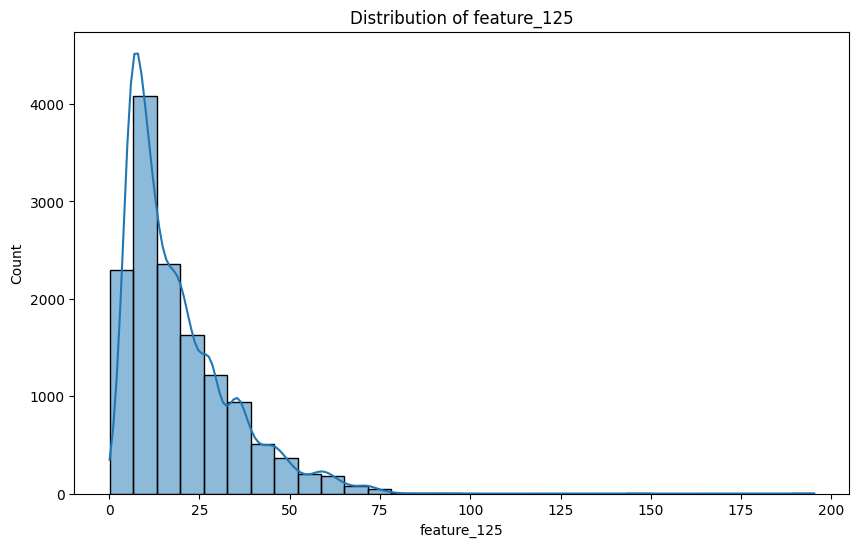

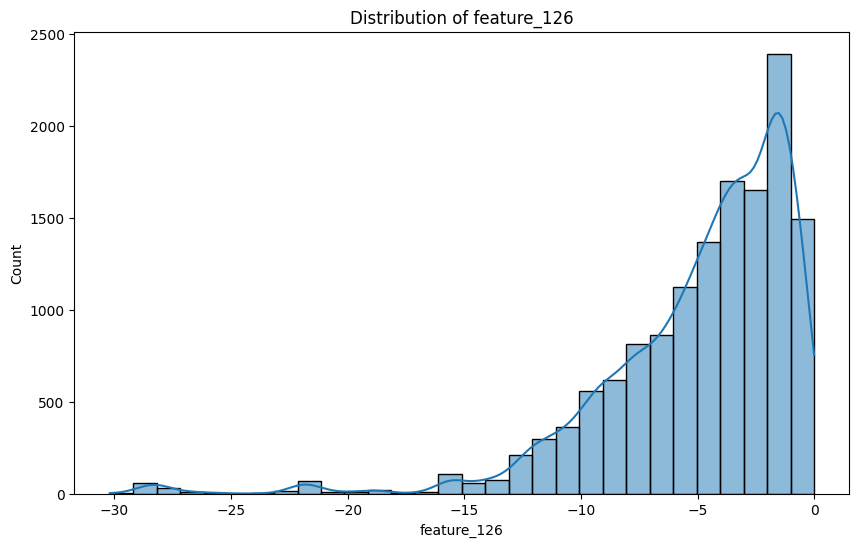

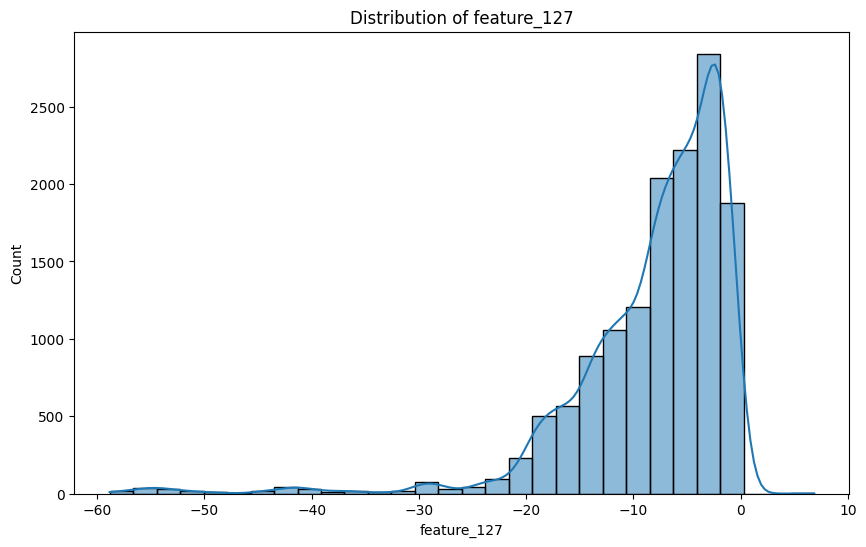

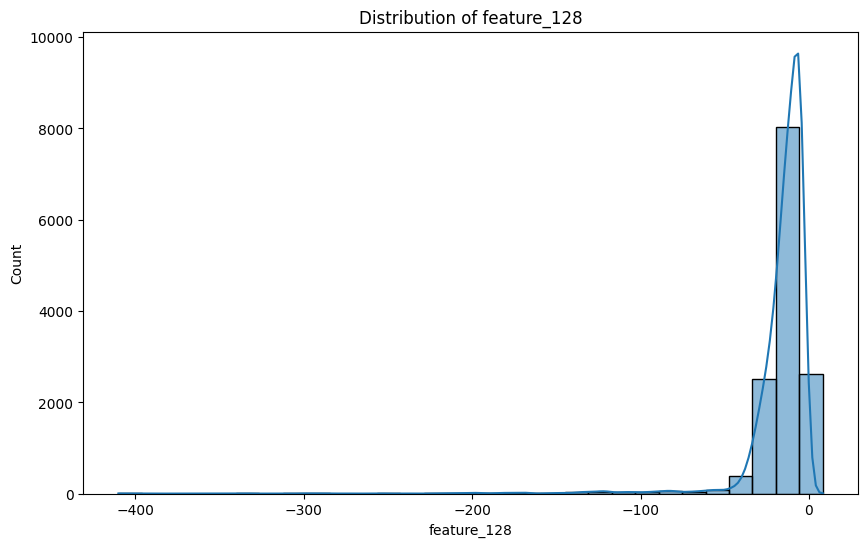

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

for column in data.columns[:-1]:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


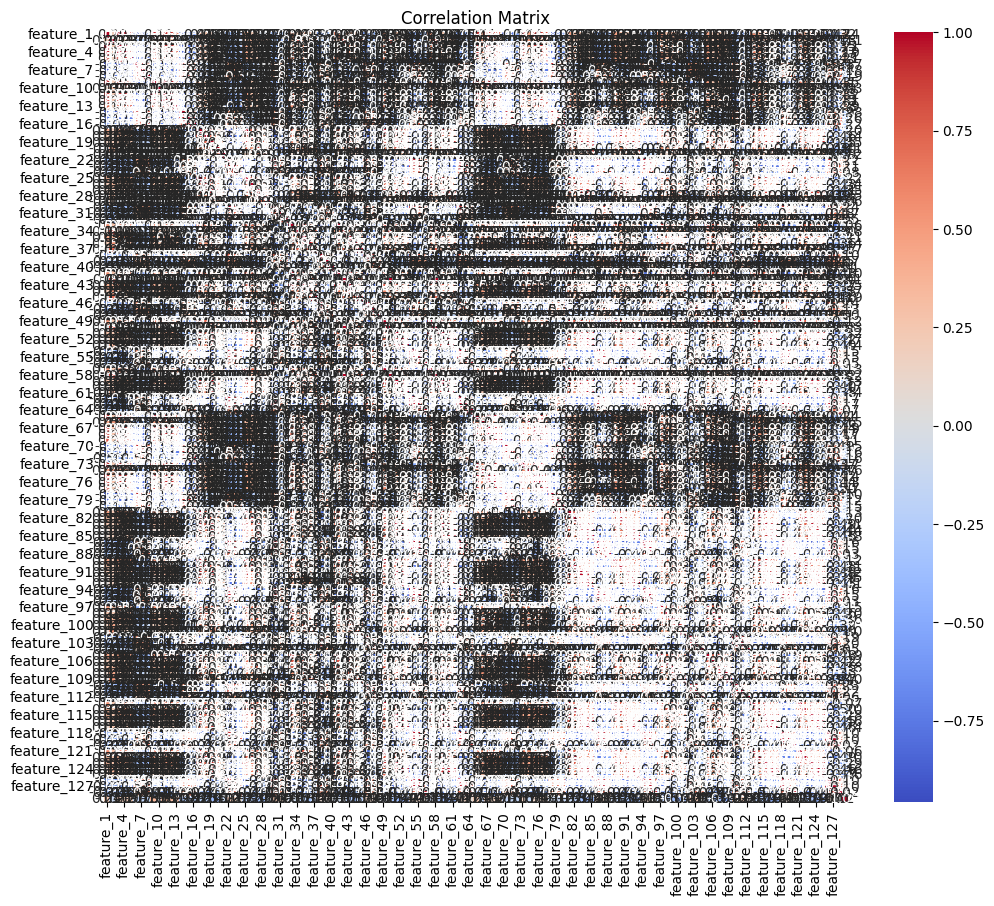

In [13]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


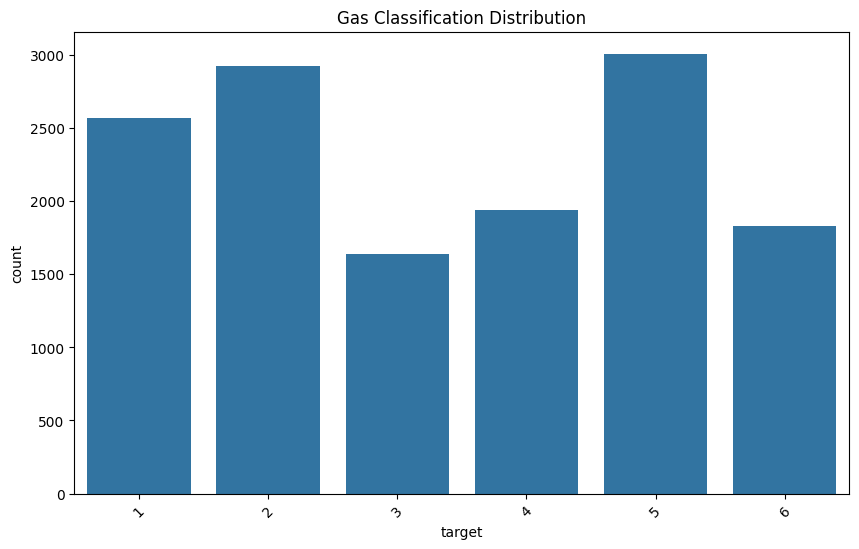

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=data)  
plt.title('Gas Classification Distribution')
plt.xticks(rotation=45)
plt.show()


In [15]:
# Calculate skewness for all numeric columns
skewness = data.skew()

# Display the skewness values
print(skewness)


feature_1       2.545258
feature_2      70.130870
feature_3       2.336018
feature_4       2.200988
feature_5       4.973879
                 ...    
feature_125     1.490849
feature_126    -2.085395
feature_127    -2.737512
feature_128    -7.364719
target          0.039874
Length: 129, dtype: float64


In [16]:
# Identify features with high skewness
high_skewness = skewness[abs(skewness) > 1]

# Display features with high skewness
print("Features with high skewness:")
print(high_skewness)


Features with high skewness:
feature_1       2.545258
feature_2      70.130870
feature_3       2.336018
feature_4       2.200988
feature_5       4.973879
                 ...    
feature_124     2.004494
feature_125     1.490849
feature_126    -2.085395
feature_127    -2.737512
feature_128    -7.364719
Length: 123, dtype: float64


In [17]:
# Count the occurrences of each class in the target variable
class_counts = data['target'].value_counts()

# Display the counts
print("Class Distribution:")
print(class_counts)

# Calculate proportions of each class
class_proportions = class_counts / class_counts.sum() * 100

# Display proportions
print("\nClass Proportions (%):")
print(class_proportions)

# Check for imbalance
threshold = 0.1  # You can adjust this threshold as needed
imbalanced_classes = class_proportions[class_proportions < threshold * 100]
if not imbalanced_classes.empty:
    print("\nImbalanced Classes:")
    print(imbalanced_classes)
else:
    print("\nNo significant imbalance detected.")


Class Distribution:
target
5    3009
2    2926
1    2565
4    1936
6    1833
3    1641
Name: count, dtype: int64

Class Proportions (%):
target
5    21.631919
2    21.035226
1    18.439971
4    13.918045
6    13.177570
3    11.797268
Name: count, dtype: float64

No significant imbalance detected.


In [18]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

def transform_skewed_features(df, skewed_features):
    pt = PowerTransformer(method='yeo-johnson')
    for feature in skewed_features.index:
        try:
            if skewed_features[feature] > 1:
                df[feature] = np.log1p(df[feature])
            df[[feature]] = pt.fit_transform(df[[feature]])
        except Exception as e:
            print(f"Skipping transformation for {feature}: {e}")
    return df

# Step 1: Calculate skewness
skewness = data.skew()

# Step 2: Identify highly skewed features
threshold = 1
high_skewed_features = skewness[abs(skewness) > threshold]

# Step 3: Apply transformations
data_transformed = transform_skewed_features(data.copy(), high_skewed_features)

# Step 4: Validate transformations
new_skewness = data_transformed.skew()
print("\nSkewness after transformation:")
print(new_skewness)


/home/moraa-ontita/Documents/Machine-learning/Gas_Sensor/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/moraa-ontita/Documents/Machine-learning/Gas_Sensor/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/moraa-ontita/Documents/Machine-learning/Gas_Sensor/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/moraa-ontita/Documents/Machine-learning/Gas_Sensor/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/moraa-ontita/Documents/Machine-learning/Gas_Sensor/.venv/lib/python3.12/site-packages/pand


Skewness after transformation:
feature_1     -0.065393
feature_2      0.031863
feature_3     -0.064025
feature_4     -0.069177
feature_5     -0.023039
                 ...   
feature_125   -0.027589
feature_126    0.000719
feature_127    0.573777
feature_128    1.849454
target         0.039874
Length: 129, dtype: float64


/home/moraa-ontita/Documents/Machine-learning/Gas_Sensor/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
# Check the data types of the columns
data_types = data.dtypes

# Print data types
print("Data Types of Columns:")
print(data_types)

# Check for object (string) columns
object_columns = data.select_dtypes(include=['object']).columns.tolist()

if object_columns:
    print("\nColumns with object data type:")
    print(object_columns)
else:
    print("\nNo columns with object data type found.")

Data Types of Columns:
feature_1      float64
feature_2      float64
feature_3      float64
feature_4      float64
feature_5      float64
                ...   
feature_125    float64
feature_126    float64
feature_127    float64
feature_128    float64
target           int64
Length: 129, dtype: object

No columns with object data type found.
